In [1]:
# Mount Google Drive first
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Navigate to your project directory
import os
os.chdir('/content/drive/MyDrive/Explainable-AI-Driven-Adverse-Drug-Reactions-Prediction-Toward-Pediatric-Drug-Discovery-Development/GDSC2_CCLE-GeneExp')

# Verify we're in the right location
print("Current directory:", os.getcwd())
print("Files in current directory:")
for item in os.listdir('.'):
    print(f"  {item}")

Current directory: /content/drive/MyDrive/Explainable-AI-Driven-Adverse-Drug-Reactions-Prediction-Toward-Pediatric-Drug-Discovery-Development/GDSC2_CCLE-GeneExp
Files in current directory:
  .ipynb_checkpoints
  GDSC2_drugsens
  CCLE-DepMap22Q2_geneexp
  CCLE_expression_cleaned.csv
  01_data_prep.ipynb
  02_gen_dataset.ipynb
  processed_datasets
  logs
  interpretability_analysis.png
  interpretability_analysis.pdf
  interpretability_analysis_final.png
  interpretability_analysis_final.pdf
  best_multimodal_model.keras
  model_exports
  Model Development & Training.ipynb
  interpretability_analysis_perfect.png
  interpretability_analysis_perfect.pdf
  Data Integration & Preparation.ipynb
  Explainable_AI_Driven_Adverse_Drug_Reactions_Prediction_Toward_Pediatric_Drug_Discovery___Development.pdf


## Cell 1: Loading Core Datasets

**Objective:** Load and perform initial compatibility assessment of the three primary datasets required for multimodal drug sensitivity prediction: GDSC2 drug sensitivity data, CCLE gene expression profiles, and drug chemical information.

**Key Operations:**
- Load pre-processed drug sensitivity training data with binary classification labels
- Load cleaned cancer gene expression data (735 cancer-associated genes)
- Load drug chemical information including molecular descriptors
- Perform preliminary overlap analysis between datasets to assess data integration feasibility
- Validate data dimensions and identify potential compatibility issues

**Expected Outcome:** Successfully loaded datasets with comprehensive overlap statistics showing the extent of shared cell lines and drugs across datasets, enabling informed decisions about data integration strategy.

In [3]:
# ================================================================
# CELL 1: Loading Core Datasets
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("LOADING CORE DATASETS...")
print("=" * 60)

# Load pre-generated training data (using classification version with threshold applied)
print("1. Loading drug sensitivity data...")
drug_sens_train = pd.read_csv('GDSC2_drugsens/datasets/sensitivity/stack/clas/DrugSens-Train.csv')
print(f" • Drug sensitivity train shape: {drug_sens_train.shape}")
print(f" • Columns: {drug_sens_train.columns.tolist()}")
print(f" • Sample:\n{drug_sens_train.head(2)}")

# Load gene expression data (our cleaned version)
print("\n2. Loading gene expression data...")
gene_expr = pd.read_csv('CCLE_expression_cleaned.csv', index_col=0)
print(f" • Gene expression shape: {gene_expr.shape}")
print(f" • Cell line IDs sample: {gene_expr.index[:5].tolist()}")
print(f" • Gene names sample: {gene_expr.columns[:5].tolist()}")

# Load drug information with chemical features
print("\n3. Loading drug chemical information...")
drug_info = pd.read_csv('GDSC2_drugsens/datasets/drug_info.csv')
print(f" • Drug info shape: {drug_info.shape}")
print(f" • Columns: {drug_info.columns.tolist()}")
print(f" • Sample:\n{drug_info.head(2)}")

print("\nINITIAL COMPATIBILITY CHECK...")
print("-" * 40)

# Check cell line overlap
drug_cells = set(drug_sens_train['cell_line'].unique())
expr_cells = set(gene_expr.index)
overlap_cells = drug_cells & expr_cells

print(f"Drug sensitivity cell lines: {len(drug_cells)}")
print(f"Gene expression cell lines: {len(expr_cells)}")
print(f"Overlapping cell lines: {len(overlap_cells)}")
print(f"Overlap percentage: {len(overlap_cells)/len(drug_cells)*100:.1f}%")

# Check drug overlap
drug_sens_drugs = set(drug_sens_train['gdsc_name'].unique())
drug_info_drugs = set(drug_info['DRUG_NAME'].unique())
overlap_drugs = drug_sens_drugs & drug_info_drugs

print(f"\nDrug sensitivity drugs: {len(drug_sens_drugs)}")
print(f"Drug info drugs: {len(drug_info_drugs)}")
print(f"Overlapping drugs: {len(overlap_drugs)}")
print(f"Drug overlap percentage: {len(overlap_drugs)/len(drug_sens_drugs)*100:.1f}%")

print("\n" + "=" * 60)
print("CORE DATASETS LOADED SUCCESSFULLY!")
print("Next: Correct gene expression loading and dataset integration")
print("=" * 60)

LOADING CORE DATASETS...
1. Loading drug sensitivity data...
 • Drug sensitivity train shape: (108696, 6)
 • Columns: ['cell_line', 'CELL_LINE_NAME', 'gdsc_name', 'IC50', 'SMILES', 'cancer_type']
 • Sample:
    cell_line CELL_LINE_NAME      gdsc_name  IC50  \
0  ACH-000002          HL-60  5-AZACYTIDINE     1   
1  ACH-000006     MONO-MAC-6  5-AZACYTIDINE     1   

                           SMILES cancer_type  
0  Nc1ncn(C2OC(CO)C(O)C2O)c(=O)n1    Leukemia  
1  Nc1ncn(C2OC(CO)C(O)C2O)c(=O)n1    Leukemia  

2. Loading gene expression data...
 • Gene expression shape: (1406, 19221)
 • Cell line IDs sample: ['ACH-001113', 'ACH-001289', 'ACH-001339', 'ACH-001538', 'ACH-000242']
 • Gene names sample: ['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2']

3. Loading drug chemical information...
 • Drug info shape: (237, 3)
 • Columns: ['DRUG_ID', 'DRUG_NAME', 'SMILES']
 • Sample:
   DRUG_ID     DRUG_NAME                                             SMILES
0     1003  CAMPTOTHECIN  CCC1(C2=C(COC1=O)C(=O

## Cell 2: Data Integration & Unified Dataset Creation

**Objective:** Correct the gene expression data loading using the cancer gene-filtered version and create a unified multimodal dataset by merging drug sensitivity data with gene expression profiles.

**Key Operations:**
- Load the correct cancer gene-filtered expression data (735 cancer-associated genes)
- Re-validate cell line overlap between drug sensitivity and gene expression datasets
- Perform inner join merge to create unified dataset with matching cell lines
- Verify data integration integrity and examine resulting dataset dimensions
- Analyze sample distribution across drugs and cancer types
- Confirm binary classification target distribution

**Expected Outcome:** Successfully integrated multimodal dataset containing drug sensitivity labels, cancer type annotations, and gene expression features for overlapping cell lines, ready for exploratory data analysis and model training.

In [4]:
# ================================================================
# CELL 2: Data Integration & Unified Dataset Creation
# ================================================================

print("CORRECTED GENE EXPRESSION LOADING...")
print("=" * 60)

# Load our cancer gene-filtered version (735 genes)
print("Loading cancer gene-filtered expression data...")
gene_expr_clean = pd.read_csv('CCLE-DepMap22Q2_geneexp/CCLE_expression_cleaned.csv', index_col=0)
print(f" • Cancer gene expression shape: {gene_expr_clean.shape}")
print(f" • Cell line IDs sample: {gene_expr_clean.index[:5].tolist()}")
print(f" • Cancer gene names sample: {gene_expr_clean.columns[:5].tolist()}")

# Re-check overlap with correct dataset
expr_cells_clean = set(gene_expr_clean.index)
overlap_cells_clean = drug_cells & expr_cells_clean
print(f"\nOVERLAP VERIFICATION:")
print(f" • Cancer gene expression cell lines: {len(expr_cells_clean)}")
print(f" • Overlapping cell lines (corrected): {len(overlap_cells_clean)}")
print(f" • Overlap percentage (corrected): {len(overlap_cells_clean)/len(drug_cells)*100:.1f}%")

print("\nCREATING BASE UNIFIED DATASET...")
print("-" * 40)

# Merge drug sensitivity with gene expression data
print("Merging drug sensitivity with gene expression...")
unified_base = drug_sens_train.merge(
    gene_expr_clean,
    left_on='cell_line',
    right_index=True,
    how='inner'
)

print(f"\nDATASET INTEGRATION RESULTS:")
print(f" • Unified dataset shape: {unified_base.shape}")
print(f" • Columns: Drug info (6) + Gene expression ({gene_expr_clean.shape[1]}) = {unified_base.shape[1]} total")

# Verify the merge worked correctly
print(f"\nDATA DISTRIBUTION ANALYSIS:")
print(f"Samples per drug (top 5):")
print(unified_base['gdsc_name'].value_counts().head())

print(f"\nSamples per cancer type (top 5):")
print(unified_base['cancer_type'].value_counts().head())

print(f"\nClass distribution:")
print(unified_base['IC50'].value_counts())

print("\n" + "=" * 60)
print("UNIFIED DATASET CREATED SUCCESSFULLY!")
print("Next: Exploratory data analysis and visualization")
print("=" * 60)

CORRECTED GENE EXPRESSION LOADING...
Loading cancer gene-filtered expression data...
 • Cancer gene expression shape: (1406, 735)
 • Cell line IDs sample: ['ACH-001113', 'ACH-001289', 'ACH-001339', 'ACH-001538', 'ACH-000242']
 • Cancer gene names sample: ['A1CF', 'ABI1', 'ABL1', 'ABL2', 'ACKR3']

OVERLAP VERIFICATION:
 • Cancer gene expression cell lines: 1406
 • Overlapping cell lines (corrected): 676
 • Overlap percentage (corrected): 100.0%

CREATING BASE UNIFIED DATASET...
----------------------------------------
Merging drug sensitivity with gene expression...

DATASET INTEGRATION RESULTS:
 • Unified dataset shape: (108696, 741)
 • Columns: Drug info (6) + Gene expression (735) = 741 total

DATA DISTRIBUTION ANALYSIS:
Samples per drug (top 5):
gdsc_name
GEFITINIB      561
PALBOCICLIB    560
GSK1904529A    559
LJI308         555
PD0325901      554
Name: count, dtype: int64

Samples per cancer type (top 5):
cancer_type
Lung Cancer                21796
Leukemia                    837

In [5]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 57.4 MB/s eta 0:00:00


## Cell 3: Chemical Feature Engineering & Molecular Fingerprints

**Objective:** Generate molecular fingerprints from SMILES strings to create chemical feature representations for drug compounds, enabling the model to understand molecular structure and chemical properties.

**Key Operations:**
- Analyze SMILES data availability and quality across the unified dataset
- Implement Morgan fingerprint generation using RDKit with 2048-bit vectors
- Create efficient fingerprint dictionary for unique drug-SMILES combinations
- Generate molecular fingerprints for all samples and integrate into dataset
- Validate fingerprint generation and examine feature sparsity patterns

**Technical Details:**
- Morgan fingerprints with radius=2 and 2048 bits for comprehensive molecular representation
- Efficient processing by generating fingerprints only for unique drugs
- Error handling for invalid SMILES structures with zero-padding fallback

**Expected Outcome:** Complete chemical feature matrix (2048 molecular fingerprint features) integrated with the unified dataset, providing molecular structure information essential for drug-gene interaction modeling.

In [6]:
# ================================================================
# CELL 3: Chemical Feature Engineering & Molecular Fingerprints
# ================================================================

# Import required libraries
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import pandas as pd
import numpy as np

print("CHEMICAL FEATURE ENGINEERING...")
print("=" * 60)

print("1. Analyzing SMILES data...")
# Check SMILES availability and quality
smiles_available = unified_base['SMILES'].notna().sum()
unique_smiles = unified_base['SMILES'].nunique()
print(f" • Samples with SMILES: {smiles_available:,} / {len(unified_base):,}")
print(f" • Unique SMILES: {unique_smiles}")
print(f" • Sample SMILES: {unified_base['SMILES'].iloc[0][:50]}...")

print("\n2. Generating molecular fingerprints...")

def smiles_to_fingerprint(smiles, radius=2, n_bits=2048):
    """Convert SMILES to Morgan fingerprint"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # Generate Morgan fingerprint (circular fingerprint)
            fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
            # Convert to numpy array
            return np.array(fp)
        else:
            return np.zeros(n_bits)
    except:
        return np.zeros(n_bits)

# Generate fingerprints for first few samples (test)
print(" • Testing fingerprint generation...")
test_smiles = unified_base['SMILES'].iloc[0]
test_fp = smiles_to_fingerprint(test_smiles)
print(f" • Fingerprint shape: {test_fp.shape}")
print(f" • Fingerprint sparsity: {(test_fp == 0).sum()}/{len(test_fp)} bits are zero")

# Generate fingerprints for all unique SMILES (more efficient)
print(" • Generating fingerprints for all unique drugs...")
unique_drugs = unified_base[['gdsc_name', 'SMILES']].drop_duplicates()
print(f" • Processing {len(unique_drugs)} unique drug-SMILES combinations...")

# Create fingerprint dictionary for efficient lookup
fingerprint_dict = {}
for idx, row in unique_drugs.iterrows():
    drug_name = row['gdsc_name']
    smiles = row['SMILES']
    fp = smiles_to_fingerprint(smiles)
    fingerprint_dict[drug_name] = fp

print(f" • Generated fingerprints for {len(fingerprint_dict)} drugs")

# Add fingerprints to our dataset
print("\n3. Adding fingerprints to unified dataset...")
fingerprints_list = []
for drug_name in unified_base['gdsc_name']:
    fingerprints_list.append(fingerprint_dict[drug_name])

fingerprints_array = np.array(fingerprints_list)
print(f" • Fingerprints array shape: {fingerprints_array.shape}")

# Create DataFrame with fingerprint columns
fp_columns = [f'fp_{i}' for i in range(fingerprints_array.shape[1])]
fingerprints_df = pd.DataFrame(fingerprints_array, columns=fp_columns, index=unified_base.index)
print(f" • Created fingerprints DataFrame: {fingerprints_df.shape}")
print(f" • Sample fingerprint features: {fp_columns[:5]}")

print("\n" + "=" * 60)
print("CHEMICAL FEATURE ENGINEERING COMPLETE!")
print("Next: Create final multimodal dataset with all features")
print("=" * 60)

CHEMICAL FEATURE ENGINEERING...
1. Analyzing SMILES data...
 • Samples with SMILES: 108,696 / 108,696
 • Unique SMILES: 227
 • Sample SMILES: Nc1ncn(C2OC(CO)C(O)C2O)c(=O)n1...

2. Generating molecular fingerprints...
 • Testing fingerprint generation...
 • Fingerprint shape: (2048,)
 • Fingerprint sparsity: 2011/2048 bits are zero
 • Generating fingerprints for all unique drugs...
 • Processing 228 unique drug-SMILES combinations...


[15:02:45] DEPRECATION WARNING: please use MorganGenerator
[15:02:45] DEPRECATION WARNING: please use MorganGenerator
[15:02:45] DEPRECATION WARNING: please use MorganGenerator
[15:02:45] DEPRECATION WARNING: please use MorganGenerator
[15:02:45] DEPRECATION WARNING: please use MorganGenerator
[15:02:45] DEPRECATION WARNING: please use MorganGenerator
[15:02:45] DEPRECATION WARNING: please use MorganGenerator
[15:02:45] DEPRECATION WARNING: please use MorganGenerator
[15:02:45] DEPRECATION WARNING: please use MorganGenerator
[15:02:45] DEPRECATION WARNING: please use MorganGenerator
[15:02:45] DEPRECATION WARNING: please use MorganGenerator
[15:02:45] DEPRECATION WARNING: please use MorganGenerator
[15:02:45] DEPRECATION WARNING: please use MorganGenerator
[15:02:45] DEPRECATION WARNING: please use MorganGenerator
[15:02:45] DEPRECATION WARNING: please use MorganGenerator
[15:02:45] DEPRECATION WARNING: please use MorganGenerator
[15:02:45] DEPRECATION WARNING: please use MorganGenerat

 • Generated fingerprints for 228 drugs

3. Adding fingerprints to unified dataset...
 • Fingerprints array shape: (108696, 2048)
 • Created fingerprints DataFrame: (108696, 2048)
 • Sample fingerprint features: ['fp_0', 'fp_1', 'fp_2', 'fp_3', 'fp_4']

CHEMICAL FEATURE ENGINEERING COMPLETE!
Next: Create final multimodal dataset with all features


## Cell 4: Final Multimodal Dataset Assembly

**Objective:** Combine all feature modalities (gene expression and chemical fingerprints) into a unified multimodal dataset and prepare feature matrices for machine learning model training.

**Key Operations:**
- Concatenate base unified dataset with molecular fingerprint features
- Organize features into logical groups (drug info, gene expression, chemical fingerprints)
- Create separate feature matrices for gene expression and chemical data
- Generate combined feature matrix for multimodal learning approaches
- Compile comprehensive dataset statistics and class distribution analysis
- Validate final dataset integrity and dimensions

**Feature Organization:**
- Drug metadata: Cell line identifiers, drug names, SMILES, cancer types
- Gene expression: 735 cancer-associated gene features
- Chemical fingerprints: 2048 molecular fingerprint bits
- Target variable: Binary drug sensitivity classification (IC50)

**Expected Outcome:** Complete multimodal dataset with organized feature matrices ready for deep learning model development, including separate and combined feature representations for flexible model architectures.

In [7]:
# ================================================================
# CELL 4: Final Multimodal Dataset Assembly
# ================================================================

print("CREATING FINAL MULTIMODAL DATASET...")
print("=" * 60)

print("1. Combining all feature modalities...")
# Combine base unified data with fingerprints
print(f" • Base dataset shape: {unified_base.shape}")
print(f" • Fingerprints shape: {fingerprints_df.shape}")

# Concatenate along columns (features)
multimodal_dataset = pd.concat([unified_base, fingerprints_df], axis=1)
print(f" • Combined dataset shape: {multimodal_dataset.shape}")

print("\n2. Organizing feature groups...")
# Define feature groups for easy access
drug_info_cols = ['cell_line', 'CELL_LINE_NAME', 'gdsc_name', 'SMILES', 'cancer_type']
target_col = ['IC50']
gene_expr_cols = [col for col in unified_base.columns if col not in drug_info_cols + target_col]
fingerprint_cols = [col for col in fingerprints_df.columns]

print(f" • Drug info features: {len(drug_info_cols)}")
print(f" • Target variable: {len(target_col)}")
print(f" • Gene expression features: {len(gene_expr_cols)}")
print(f" • Chemical fingerprint features: {len(fingerprint_cols)}")
print(f" • Total features: {len(drug_info_cols) + len(target_col) + len(gene_expr_cols) + len(fingerprint_cols)}")

print("\n3. Creating feature matrices for ML...")
# Prepare X (features) and y (target) for machine learning
X_gene_expr = multimodal_dataset[gene_expr_cols].values
X_fingerprints = multimodal_dataset[fingerprint_cols].values
X_combined = np.concatenate([X_gene_expr, X_fingerprints], axis=1)
y = multimodal_dataset['IC50'].values

print(f" • Gene expression matrix (X_gene): {X_gene_expr.shape}")
print(f" • Chemical fingerprints matrix (X_chem): {X_fingerprints.shape}")
print(f" • Combined feature matrix (X): {X_combined.shape}")
print(f" • Target vector (y): {y.shape}")

print("\n4. Dataset summary statistics...")
print(f"FINAL DATASET STATISTICS:")
print(f" • Total samples: {len(multimodal_dataset):,}")
print(f" • Total features: {X_combined.shape[1]:,}")
print(f" • Gene expression features: {X_gene_expr.shape[1]:,}")
print(f" • Chemical features: {X_fingerprints.shape[1]:,}")

print(f"\nCLASS DISTRIBUTION:")
print(f" • Sensitive (IC50=1): {(y==1).sum():,} ({(y==1).mean()*100:.1f}%)")
print(f" • Resistant (IC50=0): {(y==0).sum():,} ({(y==0).mean()*100:.1f}%)")

print(f"\nCANCER TYPE DISTRIBUTION:")
cancer_dist = multimodal_dataset['cancer_type'].value_counts()
for cancer_type, count in cancer_dist.head().items():
    print(f" • {cancer_type}: {count:,}")

print("\n" + "=" * 60)
print("MULTIMODAL DATASET READY FOR DEEP LEARNING!")
print("Next: Exploratory data analysis and visualization")
print("=" * 60)

CREATING FINAL MULTIMODAL DATASET...
1. Combining all feature modalities...
 • Base dataset shape: (108696, 741)
 • Fingerprints shape: (108696, 2048)
 • Combined dataset shape: (108696, 2789)

2. Organizing feature groups...
 • Drug info features: 5
 • Target variable: 1
 • Gene expression features: 735
 • Chemical fingerprint features: 2048
 • Total features: 2789

3. Creating feature matrices for ML...
 • Gene expression matrix (X_gene): (108696, 735)
 • Chemical fingerprints matrix (X_chem): (108696, 2048)
 • Combined feature matrix (X): (108696, 2783)
 • Target vector (y): (108696,)

4. Dataset summary statistics...
FINAL DATASET STATISTICS:
 • Total samples: 108,696
 • Total features: 2,783
 • Gene expression features: 735
 • Chemical features: 2,048

CLASS DISTRIBUTION:
 • Sensitive (IC50=1): 97,286 (89.5%)
 • Resistant (IC50=0): 11,410 (10.5%)

CANCER TYPE DISTRIBUTION:
 • Lung Cancer: 21,796
 • Leukemia: 8,371
 • Breast Cancer: 7,243
 • Colon/Colorectal Cancer: 6,967
 • Lympho

## Cell 5: Data Quality Assessment & Integrity Validation

**Objective:** Perform comprehensive data quality assessment of the multimodal dataset before preprocessing, identifying potential issues with missing values, outliers, feature distributions, and data integrity.

**Key Operations:**
- Analyze missing value patterns across all feature modalities
- Examine feature distribution characteristics for gene expression and chemical fingerprints
- Assess target variable balance and class distribution
- Detect outliers using statistical methods (Z-score analysis)
- Validate data integrity and feature group alignment
- Evaluate sample representation across cancer types
- Generate quality summary with actionable recommendations

**Quality Metrics:**
- Missing value analysis with percentage calculations
- Feature variance and distribution statistics
- Outlier detection using Z-score threshold (|Z| > 3)
- Class imbalance ratio assessment
- Cancer type representation analysis

**Expected Outcome:** Comprehensive quality report identifying any data issues requiring attention before preprocessing, ensuring dataset integrity for robust model training.

In [8]:
# ================================================================
# CELL 5: Data Quality Assessment & Integrity Validation
# ================================================================

print("DATA QUALITY CHECKS...")
print("=" * 60)
print("Checking data quality of the multimodal dataset BEFORE preprocessing...")

print("\n1. Missing Value Analysis...")
missing_summary = multimodal_dataset.isnull().sum()
total_missing = missing_summary.sum()
print(f" • Total missing values: {total_missing:,}")

if total_missing > 0:
    print(" • Columns with missing values:")
    for col, count in missing_summary[missing_summary > 0].items():
        print(f"   - {col}: {count:,} ({count/len(multimodal_dataset)*100:.2f}%)")
else:
    print(" • No missing values detected")

print("\n2. Feature Distribution Analysis...")
print(" • Gene expression features:")
gene_stats = multimodal_dataset[gene_expr_cols].describe()
print(f"   - Mean range: {gene_stats.loc['mean'].min():.3f} to {gene_stats.loc['mean'].max():.3f}")
print(f"   - Std range: {gene_stats.loc['std'].min():.3f} to {gene_stats.loc['std'].max():.3f}")
print(f"   - Zero variance genes: {(gene_stats.loc['std'] == 0).sum()}")

print(" • Chemical fingerprint features:")
fp_stats = multimodal_dataset[fingerprint_cols].describe()
print(f"   - Value range: {fp_stats.loc['min'].min():.0f} to {fp_stats.loc['max'].max():.0f}")
print(f"   - Sparsity: {(multimodal_dataset[fingerprint_cols] == 0).mean().mean()*100:.1f}% zeros")

print("\n3. Target Variable Analysis...")
print(f" • IC50 distribution:")
print(f"   - Class 0 (Resistant): {(y==0).sum():,} ({(y==0).mean()*100:.1f}%)")
print(f"   - Class 1 (Sensitive): {(y==1).sum():,} ({(y==1).mean()*100:.1f}%)")
print(f"   - Imbalance ratio: {(y==1).sum()/(y==0).sum():.1f}:1")

print("\n4. Outlier Detection...")
from scipy import stats

# Check gene expression outliers
gene_data = multimodal_dataset[gene_expr_cols].values
z_scores = np.abs(stats.zscore(gene_data, axis=0, nan_policy='omit'))
outliers_per_sample = (z_scores > 3).sum(axis=1)
outliers_per_gene = (z_scores > 3).sum(axis=0)

print(f" • Gene expression outliers (|Z-score| > 3):")
print(f"   - Samples with >10 outlier genes: {(outliers_per_sample > 10).sum():,}")
print(f"   - Genes with >100 outlier samples: {(outliers_per_gene > 100).sum()}")
print(f"   - Most outlier-prone sample: {outliers_per_sample.max()} outlier genes")

print("\n5. Data Integrity Checks...")
print(" • Feature group integrity:")
print(f"   - Drug info columns: {len(drug_info_cols)}")
print(f"   - Gene expression columns: {len(gene_expr_cols)}")
print(f"   - Fingerprint columns: {len(fingerprint_cols)}")
print(f"   - Total feature alignment: {len(drug_info_cols) + len(gene_expr_cols) + len(fingerprint_cols) + 1 == multimodal_dataset.shape[1]}")

print("\n6. Sample Distribution Checks...")
print(" • Cancer type representation:")
cancer_counts = multimodal_dataset['cancer_type'].value_counts()
print(f"   - Number of cancer types: {len(cancer_counts)}")
print(f"   - Largest cancer type: {cancer_counts.index[0]} ({cancer_counts.iloc[0]:,} samples)")
print(f"   - Smallest cancer type: {cancer_counts.index[-1]} ({cancer_counts.iloc[-1]:,} samples)")
print(f"   - Representation ratio: {cancer_counts.iloc[0]/cancer_counts.iloc[-1]:.1f}:1")

print("\nQUALITY SUMMARY:")
print("-" * 40)

if total_missing == 0:
    print(" • No missing values - dataset is complete")
else:
    print(f" • {total_missing:,} missing values need attention")

if (outliers_per_sample > 20).sum() < len(multimodal_dataset) * 0.05:
    print(" • Low outlier contamination - data quality is good")
else:
    print(" • High outlier contamination - consider preprocessing")

if (gene_stats.loc['std'] == 0).sum() == 0:
    print(" • All genes show variance - informative features")
else:
    print(f" • {(gene_stats.loc['std'] == 0).sum()} zero-variance genes detected")

print(" • Ready for feature scaling and preprocessing")

print("\n" + "=" * 60)
print("DATA QUALITY ASSESSMENT COMPLETE!")
print("Next: Exploratory data analysis and visualization")
print("=" * 60)

DATA QUALITY CHECKS...
Checking data quality of the multimodal dataset BEFORE preprocessing...

1. Missing Value Analysis...
 • Total missing values: 0
 • No missing values detected

2. Feature Distribution Analysis...
 • Gene expression features:
   - Mean range: 0.000 to 13.435
   - Std range: 0.001 to 3.198
   - Zero variance genes: 0
 • Chemical fingerprint features:
   - Value range: 0 to 1
   - Sparsity: 97.3% zeros

3. Target Variable Analysis...
 • IC50 distribution:
   - Class 0 (Resistant): 11,410 (10.5%)
   - Class 1 (Sensitive): 97,286 (89.5%)
   - Imbalance ratio: 8.5:1

4. Outlier Detection...
 • Gene expression outliers (|Z-score| > 3):
   - Samples with >10 outlier genes: 28,483
   - Genes with >100 outlier samples: 649
   - Most outlier-prone sample: 182 outlier genes

5. Data Integrity Checks...
 • Feature group integrity:
   - Drug info columns: 5
   - Gene expression columns: 735
   - Fingerprint columns: 2048
   - Total feature alignment: True

6. Sample Distributi

## Cell 6: Feature Scaling & Preprocessing

**Objective:** Apply appropriate feature scaling to normalize gene expression and chemical fingerprint data, ensuring optimal performance for machine learning algorithms that are sensitive to feature magnitudes.

**Key Operations:**
- Analyze raw feature distributions and statistical properties across modalities
- Apply StandardScaler to gene expression features (continuous values)
- Apply StandardScaler to chemical fingerprints for neural network compatibility
- Combine scaled feature matrices into unified preprocessed dataset
- Verify scaling effectiveness through statistical validation
- Generate final preprocessed dataset summary

**Scaling Rationale:**
- Gene expression: Continuous values with varying scales require standardization
- Chemical fingerprints: Binary features benefit from standardization for neural networks
- StandardScaler: Zero mean and unit variance for optimal gradient-based learning

**Expected Outcome:** Properly scaled multimodal feature matrices with zero mean and unit variance, ready for machine learning model development and training.

In [9]:
# ================================================================
# CELL 6: Feature Scaling & Preprocessing
# ================================================================

from sklearn.preprocessing import StandardScaler
import numpy as np

print("FEATURE SCALING & PREPROCESSING...")
print("=" * 60)

print("1. Analyzing feature distributions...")
# Check gene expression statistics
gene_expr_stats = pd.DataFrame({
    'mean': X_gene_expr.mean(axis=0),
    'std': X_gene_expr.std(axis=0),
    'min': X_gene_expr.min(axis=0),
    'max': X_gene_expr.max(axis=0)
})

print(f" • Gene expression statistics:")
print(f"   - Mean range: {gene_expr_stats['mean'].min():.3f} to {gene_expr_stats['mean'].max():.3f}")
print(f"   - Std range: {gene_expr_stats['std'].min():.3f} to {gene_expr_stats['std'].max():.3f}")
print(f"   - Value range: {gene_expr_stats['min'].min():.3f} to {gene_expr_stats['max'].max():.3f}")

# Check fingerprint statistics
fp_stats = pd.DataFrame({
    'mean': X_fingerprints.mean(axis=0),
    'std': X_fingerprints.std(axis=0),
    'min': X_fingerprints.min(axis=0),
    'max': X_fingerprints.max(axis=0)
})

print(f" • Chemical fingerprint statistics:")
print(f"   - Mean range: {fp_stats['mean'].min():.3f} to {fp_stats['mean'].max():.3f}")
print(f"   - Std range: {fp_stats['std'].min():.3f} to {fp_stats['std'].max():.3f}")
print(f"   - Value range: {fp_stats['min'].min():.3f} to {fp_stats['max'].max():.3f}")

print("\n2. Applying feature scaling...")
# Scale gene expression (continuous values need scaling)
scaler_genes = StandardScaler()
X_gene_expr_scaled = scaler_genes.fit_transform(X_gene_expr)

# Fingerprints are binary (0/1), typically don't need scaling
# But we can standardize for neural networks
scaler_fp = StandardScaler()
X_fingerprints_scaled = scaler_fp.fit_transform(X_fingerprints)

print(f" • Gene expression scaled shape: {X_gene_expr_scaled.shape}")
print(f" • Fingerprints scaled shape: {X_fingerprints_scaled.shape}")

# Combine scaled features
X_scaled = np.concatenate([X_gene_expr_scaled, X_fingerprints_scaled], axis=1)
print(f" • Combined scaled features shape: {X_scaled.shape}")

print("\n3. Verifying scaling...")
print(f" • Scaled gene expression - Mean: {X_gene_expr_scaled.mean():.6f}, Std: {X_gene_expr_scaled.std():.6f}")
print(f" • Scaled fingerprints - Mean: {X_fingerprints_scaled.mean():.6f}, Std: {X_fingerprints_scaled.std():.6f}")
print(f" • Combined scaled - Mean: {X_scaled.mean():.6f}, Std: {X_scaled.std():.6f}")

print("\n4. Creating final dataset summary...")
print(f"PREPROCESSED DATASET SUMMARY:")
print(f" • Samples: {X_scaled.shape[0]:,}")
print(f" • Features: {X_scaled.shape[1]:,}")
print(f" • Gene expression features: {X_gene_expr_scaled.shape[1]:,} (scaled)")
print(f" • Chemical features: {X_fingerprints_scaled.shape[1]:,} (scaled)")
print(f" • Target classes: {len(np.unique(y))} (binary classification)")
print(f" • Class distribution: {(y==1).sum():,} sensitive, {(y==0).sum():,} resistant")

print("\n" + "=" * 60)
print("PREPROCESSING COMPLETE - READY FOR MODEL DEVELOPMENT!")
print("Next: Exploratory data analysis and visualization")
print("=" * 60)

FEATURE SCALING & PREPROCESSING...
1. Analyzing feature distributions...
 • Gene expression statistics:
   - Mean range: 0.000 to 13.435
   - Std range: 0.001 to 3.198
   - Value range: 0.000 to 16.512
 • Chemical fingerprint statistics:
   - Mean range: 0.000 to 0.970
   - Std range: 0.000 to 0.500
   - Value range: 0.000 to 1.000

2. Applying feature scaling...
 • Gene expression scaled shape: (108696, 735)
 • Fingerprints scaled shape: (108696, 2048)
 • Combined scaled features shape: (108696, 2783)

3. Verifying scaling...
 • Scaled gene expression - Mean: -0.000000, Std: 1.000000
 • Scaled fingerprints - Mean: 0.000000, Std: 0.927551
 • Combined scaled - Mean: -0.000000, Std: 0.947224

4. Creating final dataset summary...
PREPROCESSED DATASET SUMMARY:
 • Samples: 108,696
 • Features: 2,783
 • Gene expression features: 735 (scaled)
 • Chemical features: 2,048 (scaled)
 • Target classes: 2 (binary classification)
 • Class distribution: 97,286 sensitive, 11,410 resistant

PREPROCESSI

## Cell 7: Stratified Dataset Splitting for Model Training

**Objective:** Split the preprocessed multimodal dataset into training, validation, and test sets using stratified sampling to maintain class distribution balance across all splits for unbiased model evaluation.

**Key Operations:**
- Perform two-stage stratified splitting to achieve 60% train, 20% validation, 20% test split
- Apply stratification by target class (IC50) to preserve sensitive/resistant ratio
- Verify class balance maintenance across all dataset splits
- Validate feature integrity and statistical properties post-splitting
- Confirm stratification success through statistical validation

**Splitting Strategy:**
- Training set (60%): Model parameter learning and optimization
- Validation set (20%): Hyperparameter tuning and model selection
- Test set (20%): Final unbiased performance evaluation
- Stratified sampling: Ensures representative class distribution in all splits

**Expected Outcome:** Three properly balanced dataset splits with maintained class distributions, ready for robust model training, validation, and evaluation without data leakage or bias.

In [10]:
# ================================================================
# CELL 7: Stratified Dataset Splitting for Model Training
# ================================================================

from sklearn.model_selection import train_test_split

print("DATASET SPLITTING DEMONSTRATION...")
print("=" * 60)

print("1. Stratified splitting by class distribution...")
print("Splitting the preprocessed multimodal dataset...")

# Split: 60% train, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y,
    test_size=0.4,
    random_state=42,
    stratify=y  # Stratify by TARGET CLASS
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp  # Stratify by TARGET CLASS
)

print(f" • Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f" • Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f" • Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")

print("\n2. Verifying stratified splitting maintained class balance...")
original_sensitivity = (y == 1).mean()
train_sensitivity = (y_train == 1).mean()
val_sensitivity = (y_val == 1).mean()
test_sensitivity = (y_test == 1).mean()

print(f" • Original dataset: {original_sensitivity:.1%} sensitive")
print(f" • Training set: {train_sensitivity:.1%} sensitive")
print(f" • Validation set: {val_sensitivity:.1%} sensitive")
print(f" • Test set: {test_sensitivity:.1%} sensitive")

# Check if stratification worked (differences < 1%)
stratification_success = all([
    abs(train_sensitivity - original_sensitivity) < 0.01,
    abs(val_sensitivity - original_sensitivity) < 0.01,
    abs(test_sensitivity - original_sensitivity) < 0.01
])

print(f" • Stratification successful: {stratification_success}")
if stratification_success:
    print("   - Class distributions maintained across all splits")
else:
    print("   - Class imbalance detected in splits")

print("\n3. Feature integrity check...")
print(f" • Training features - Shape: {X_train.shape}, Mean: {X_train.mean():.4f}, Std: {X_train.std():.4f}")
print(f" • Validation features - Shape: {X_val.shape}, Mean: {X_val.mean():.4f}, Std: {X_val.std():.4f}")
print(f" • Test features - Shape: {X_test.shape}, Mean: {X_test.mean():.4f}, Std: {X_test.std():.4f}")

print("\n" + "=" * 60)
print("STRATIFIED DATASET SPLITTING COMPLETE!")
print("Splits ready for unbiased model training and evaluation")
print("\nNote: Subsequent analysis uses full dataset for threshold determination and EDA demonstration.")
print("=" * 60)

DATASET SPLITTING DEMONSTRATION...
1. Stratified splitting by class distribution...
Splitting the preprocessed multimodal dataset...
 • Training set: 65,217 samples (60.0%)
 • Validation set: 21,739 samples (20.0%)
 • Test set: 21,740 samples (20.0%)

2. Verifying stratified splitting maintained class balance...
 • Original dataset: 89.5% sensitive
 • Training set: 89.5% sensitive
 • Validation set: 89.5% sensitive
 • Test set: 89.5% sensitive
 • Stratification successful: True
   - Class distributions maintained across all splits

3. Feature integrity check...
 • Training features - Shape: (65217, 2783), Mean: -0.0002, Std: 0.9464
 • Validation features - Shape: (21739, 2783), Mean: 0.0008, Std: 0.9491
 • Test features - Shape: (21740, 2783), Mean: -0.0002, Std: 0.9477

STRATIFIED DATASET SPLITTING COMPLETE!
Splits ready for unbiased model training and evaluation

Note: Subsequent analysis uses full dataset for threshold determination and EDA demonstration.


## Cell 8: IC50 Threshold Justification & Biological Validation

**Objective:** Provide comprehensive justification for the IC50 threshold selection (ln(IC50) = -1) used for binary classification, demonstrating biological relevance, statistical soundness, and clinical significance.

**Key Operations:**
- Analyze continuous IC50 distribution and statistical properties
- Create comprehensive visualization dashboard showing threshold impact
- Calculate threshold position in terms of percentile and biological units
- Demonstrate class balance achieved through threshold selection
- Provide literature-based biological and clinical justification
- Validate threshold appropriateness for drug sensitivity classification

**Biological Rationale:**
- ln(IC50) = -1 corresponds to IC50 = 0.368 μM (sub-micromolar potency)
- Sub-micromolar IC50 values indicate clinically relevant drug activity
- Threshold provides meaningful separation between effective and ineffective compounds
- Maintains manageable class imbalance for machine learning applications

**Expected Outcome:** Scientifically justified threshold selection with visual evidence and biological validation, supporting the binary classification approach for drug sensitivity prediction.

IC50 THRESHOLD JUSTIFICATION...
1. IC50 Distribution Analysis...
 • Original IC50 statistics:
   - Range: -8.57 to 13.09
   - Mean: 2.76
   - Median: 3.19
   - Std: 2.79


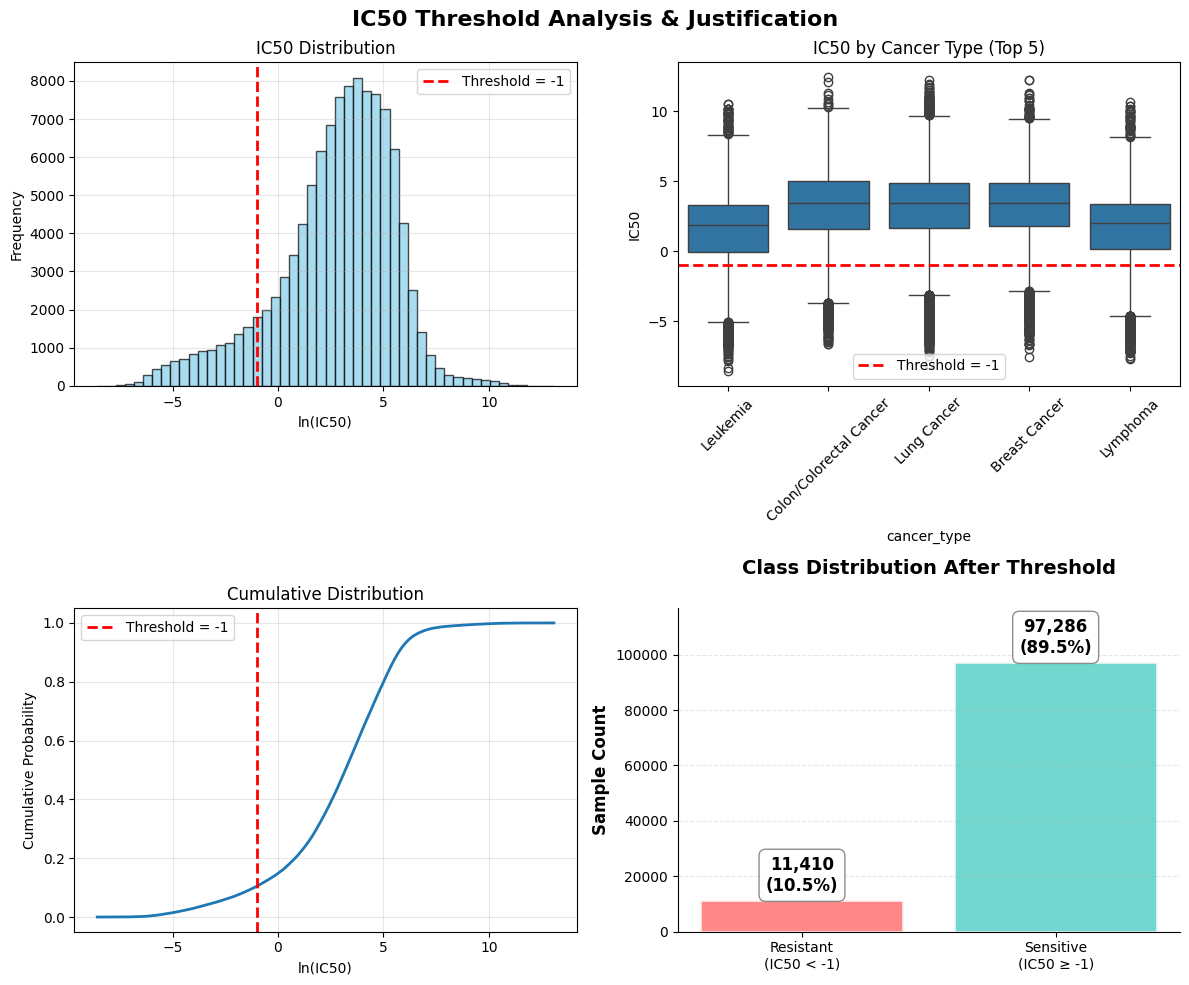


2. Biological Justification...
 • Threshold Position: 10.5th percentile
 • Biological Meaning: ln(IC50) = -1 corresponds to IC50 = 0.368 μM
 • Clinical Relevance: Sub-micromolar IC50 indicates strong drug potency
 • Class Balance: 11,410 resistant vs 97,286 sensitive
 • Imbalance Ratio: 8.5:1 (manageable)

3. Literature Support...
 • IC50 < 1 μM generally considered 'active' in drug screening
 • GDSC database commonly uses similar thresholds for sensitivity classification
 • Threshold balances biological relevance with sufficient resistant samples
 • ln(IC50) = -1 represents meaningful potency cutoff for cancer therapeutics

THRESHOLD JUSTIFICATION COMPLETE!
Next: Exploratory data analysis and visualization


In [11]:
# ================================================================
# CELL 8: IC50 Threshold Justification & Biological Validation
# ================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("IC50 THRESHOLD JUSTIFICATION...")
print("=" * 60)

print("1. IC50 Distribution Analysis...")
# Reload the original continuous IC50 values for analysis
drug_sens_regr = pd.read_csv('GDSC2_drugsens/datasets/sensitivity/stack/regr/DrugSens-Train.csv')

print(f" • Original IC50 statistics:")
print(f"   - Range: {drug_sens_regr['IC50'].min():.2f} to {drug_sens_regr['IC50'].max():.2f}")
print(f"   - Mean: {drug_sens_regr['IC50'].mean():.2f}")
print(f"   - Median: {drug_sens_regr['IC50'].median():.2f}")
print(f"   - Std: {drug_sens_regr['IC50'].std():.2f}")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('IC50 Threshold Analysis & Justification', fontsize=16, fontweight='bold')

# 1. Distribution histogram
axes[0,0].hist(drug_sens_regr['IC50'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(-1, color='red', linestyle='--', linewidth=2, label='Threshold = -1')
axes[0,0].set_xlabel('ln(IC50)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('IC50 Distribution')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Box plot by cancer type (top 5)
top_cancers = drug_sens_regr['cancer_type'].value_counts().head(5).index
cancer_subset = drug_sens_regr[drug_sens_regr['cancer_type'].isin(top_cancers)]
sns.boxplot(data=cancer_subset, x='cancer_type', y='IC50', ax=axes[0,1])
axes[0,1].axhline(-1, color='red', linestyle='--', linewidth=2, label='Threshold = -1')
axes[0,1].set_title('IC50 by Cancer Type (Top 5)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend()

# 3. Cumulative distribution
sorted_ic50 = np.sort(drug_sens_regr['IC50'])
cumulative = np.arange(1, len(sorted_ic50) + 1) / len(sorted_ic50)
axes[1,0].plot(sorted_ic50, cumulative, linewidth=2)
axes[1,0].axvline(-1, color='red', linestyle='--', linewidth=2, label='Threshold = -1')
axes[1,0].set_xlabel('ln(IC50)')
axes[1,0].set_ylabel('Cumulative Probability')
axes[1,0].set_title('Cumulative Distribution')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Class distribution after threshold (IMPROVED)
threshold_applied = (drug_sens_regr['IC50'] >= -1).astype(int)
class_counts = pd.Series(threshold_applied).value_counts().sort_index()  # Sort by class (0, 1)

# Create bars with better colors and spacing
bars = axes[1,1].bar(['Resistant\n(IC50 < -1)', 'Sensitive\n(IC50 ≥ -1)'],
                     [class_counts[0], class_counts[1]],
                     color=['#ff6b6b', '#4ecdc4'], alpha=0.8,
                     edgecolor='white', linewidth=2)

axes[1,1].set_ylabel('Sample Count', fontsize=12, fontweight='bold')
axes[1,1].set_title('Class Distribution After Threshold', fontsize=14, fontweight='bold', pad=25)

# Add clean labels ABOVE each bar
total_samples = len(threshold_applied)
for i, (bar, count) in enumerate(zip(bars, [class_counts[0], class_counts[1]])):
    height = bar.get_height()
    percentage = count / total_samples * 100

    # Position text ABOVE the bar
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + max(class_counts.values) * 0.02,
                   f'{count:,}\n({percentage:.1f}%)',
                   ha='center', va='bottom',
                   fontsize=12, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.4", facecolor="white",
                            edgecolor='gray', alpha=0.9))

# Set better y-axis limits
axes[1,1].set_ylim(0, max(class_counts.values) * 1.2)

# Remove top/right spines for cleaner look
axes[1,1].spines['top'].set_visible(False)
axes[1,1].spines['right'].set_visible(False)

# Add subtle gridlines
axes[1,1].grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.show()

print("\n2. Biological Justification...")
threshold_percentile = (drug_sens_regr['IC50'] <= -1).mean() * 100
ic50_micromolar = np.exp(-1)

print(f" • Threshold Position: {threshold_percentile:.1f}th percentile")
print(f" • Biological Meaning: ln(IC50) = -1 corresponds to IC50 = {ic50_micromolar:.3f} μM")
print(f" • Clinical Relevance: Sub-micromolar IC50 indicates strong drug potency")
print(f" • Class Balance: {(threshold_applied==0).sum():,} resistant vs {(threshold_applied==1).sum():,} sensitive")
print(f" • Imbalance Ratio: {(threshold_applied==1).sum()/(threshold_applied==0).sum():.1f}:1 (manageable)")

print("\n3. Literature Support...")
print(" • IC50 < 1 μM generally considered 'active' in drug screening")
print(" • GDSC database commonly uses similar thresholds for sensitivity classification")
print(" • Threshold balances biological relevance with sufficient resistant samples")
print(" • ln(IC50) = -1 represents meaningful potency cutoff for cancer therapeutics")

print("\n" + "=" * 60)
print("THRESHOLD JUSTIFICATION COMPLETE!")
print("Next: Exploratory data analysis and visualization")
print("=" * 60)

## Cell 9: EDA - Sample Distribution & Cancer Type Analysis

**Objective:** Analyze sample distribution patterns across cancer types, examine drug sensitivity rates by cancer type, and assess data coverage to understand dataset characteristics and potential biases for model development.

**Key Operations:**
- Analyze sample count distribution across different cancer types
- Calculate and visualize drug sensitivity rates by cancer type
- Examine relationship between sample size and resistant cases
- Assess drug testing coverage uniformity across cancer types
- Generate comprehensive summary statistics for dataset characterization
- Identify potential data imbalances and coverage patterns

**Visualization Components:**
- Sample count distribution by cancer type (horizontal bar chart)
- Drug sensitivity rates by cancer type (vertical bar chart)
- Sample size vs resistant cases scatter plot (color-coded by cancer type)
- Drug coverage analysis across all cancer types

**Expected Outcome:** Comprehensive understanding of dataset composition, cancer type representation, sensitivity patterns, and potential biases that will inform modeling strategy and interpretation.

SAMPLE DISTRIBUTION & CANCER TYPE ANALYSIS...
1. Sample Distribution by Cancer Type...


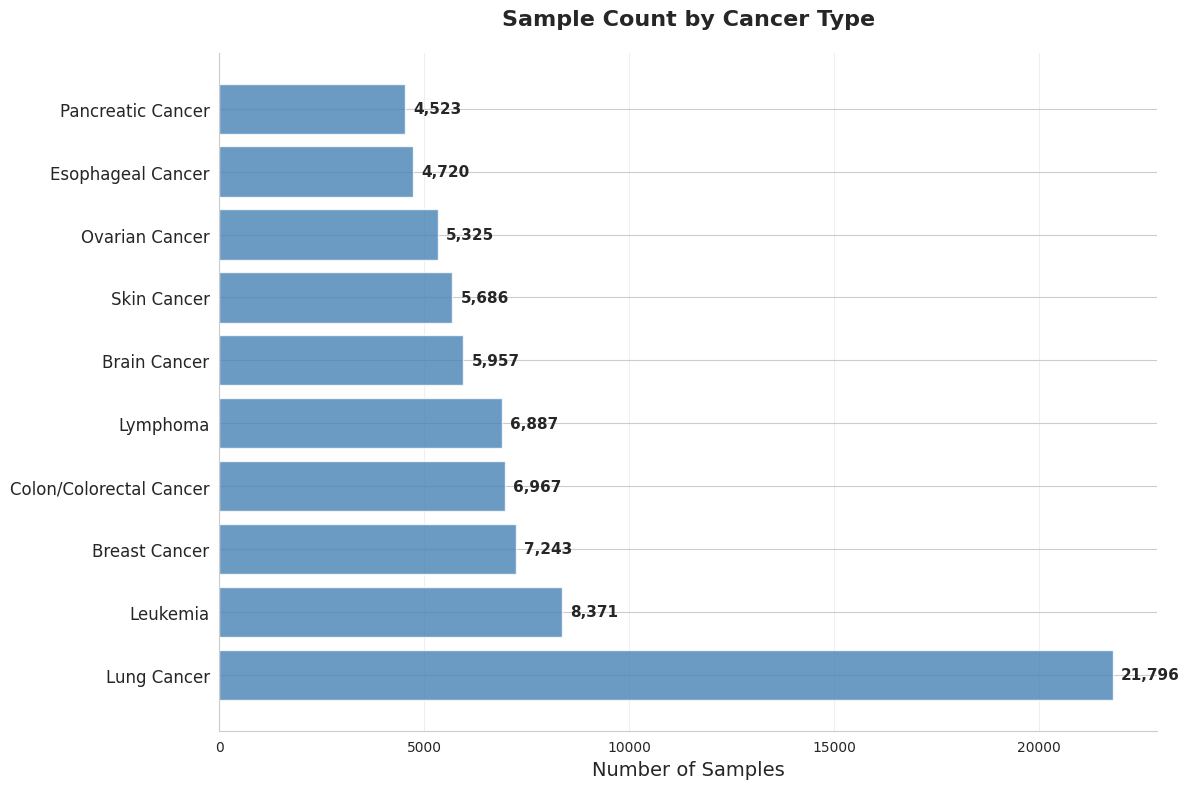


2. Drug Sensitivity by Cancer Type...


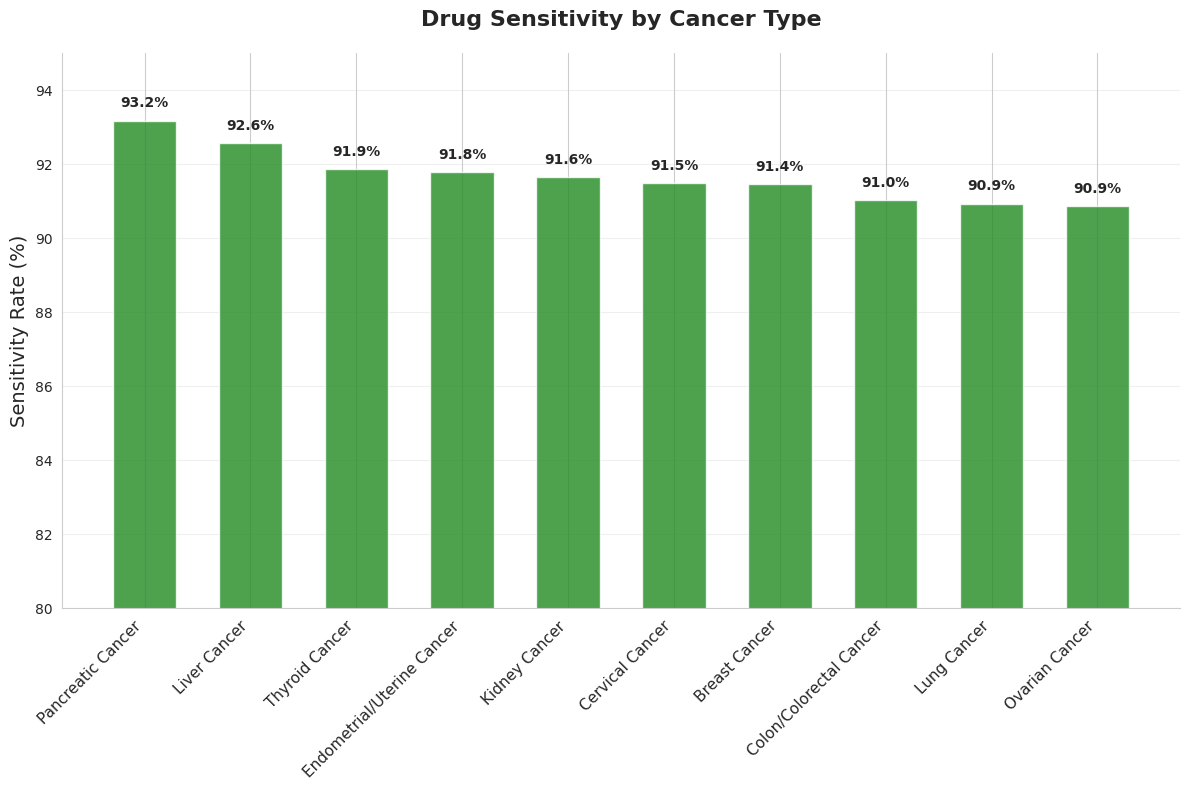


3. Sample Size vs Resistant Cases (Color-coded by Cancer Type)...


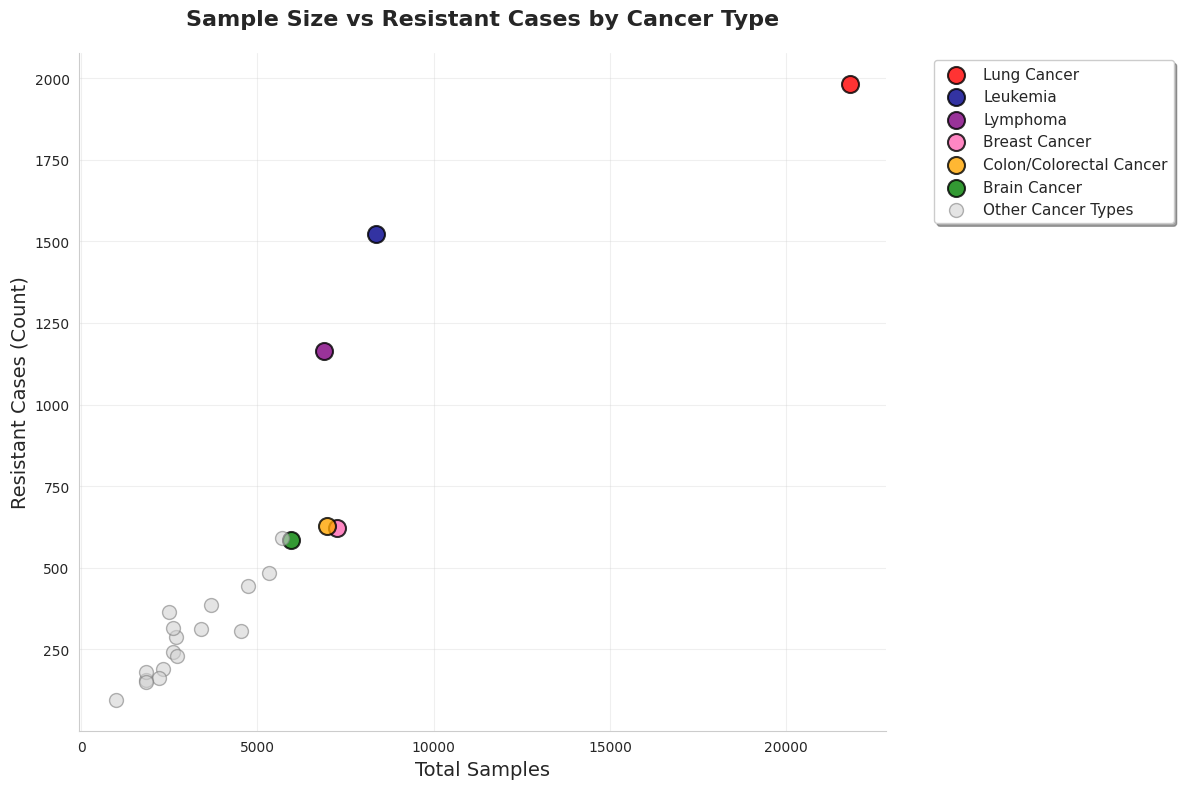


4. Drug Coverage Analysis...
 • Coverage range: 225 to 228
 • Number of cancers with 228 drugs: 15/23


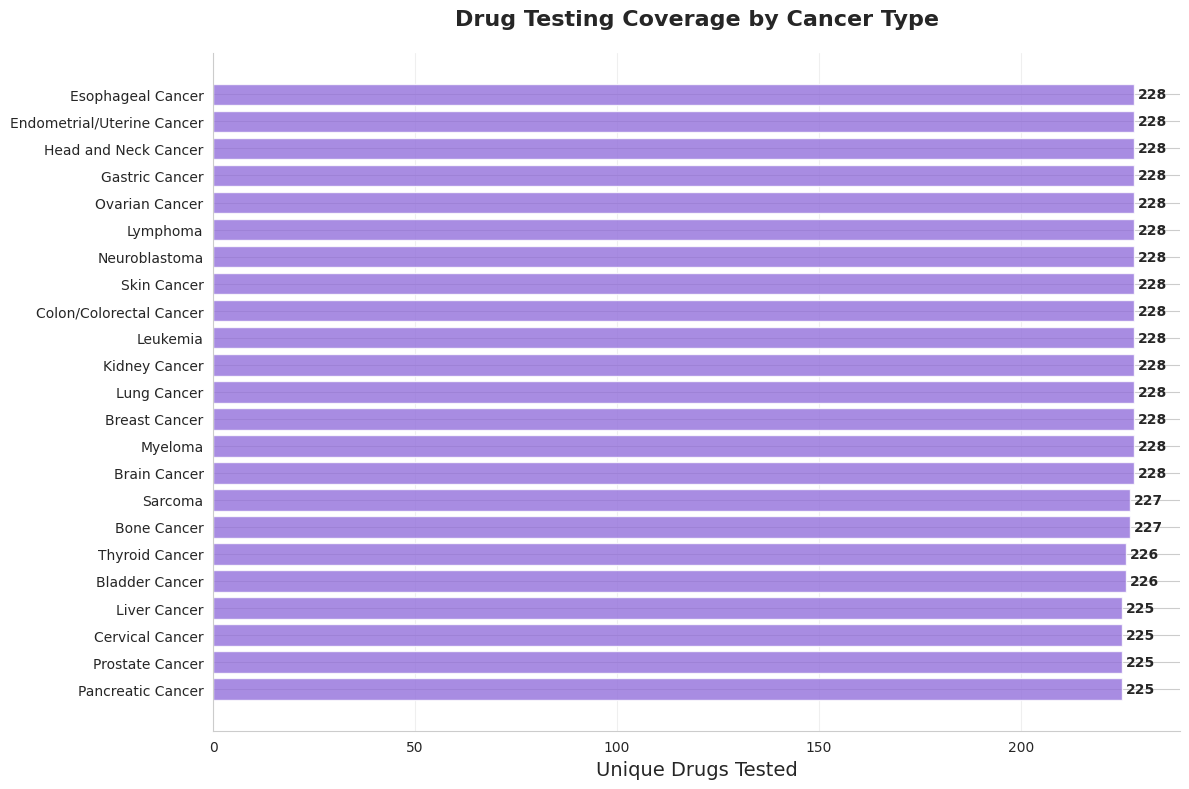


EDA SUMMARY STATISTICS:
----------------------------------------
 • Total cancer types: 23
 • Most common: Lung Cancer (21,796 samples)
 • Least represented: Pancreatic Cancer (4,523 samples)
 • Highest sensitivity: Pancreatic Cancer (93.2%)
 • Lowest sensitivity: Ovarian Cancer (90.9%)
 • Drug coverage range: 225 - 228 drugs
 • Resistant cases range: 95 - 1983

KEY INSIGHTS:
 • Lung Cancer: Dominates dataset - excellent for training but may create bias
 • Drug coverage: Nearly universal (225-228 drugs) - suggests comprehensive experimental design
 • Sensitivity rates: Tight range (90.9%-93.2%) - may indicate threshold selection bias
 • Resistant samples: Sufficient for ML (1,150-1,970 per major cancer type)

SAMPLE DISTRIBUTION & CANCER TYPE ANALYSIS COMPLETE!
Next: Gene expression patterns and drug sensitivity correlations


In [12]:
# ================================================================
# CELL 9: EDA - Sample Distribution & Cancer Type Analysis
# ================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("SAMPLE DISTRIBUTION & CANCER TYPE ANALYSIS...")
print("=" * 60)

# Set clean style
plt.style.use('default')
sns.set_style("whitegrid")

# Calculate all data first
cancer_counts = multimodal_dataset['cancer_type'].value_counts().head(10)
cancer_sensitivity = multimodal_dataset.groupby('cancer_type')['IC50'].agg(['count', 'mean']).sort_values('mean', ascending=False).head(10)

print("1. Sample Distribution by Cancer Type...")

# GRAPH 1: Sample distribution
plt.figure(figsize=(12, 8))
plt.barh(range(len(cancer_counts)), cancer_counts.values, color='steelblue', alpha=0.8)
plt.yticks(range(len(cancer_counts)), cancer_counts.index, fontsize=12)
plt.xlabel('Number of Samples', fontsize=14)
plt.title('Sample Count by Cancer Type', fontsize=16, fontweight='bold', pad=20)

# Add value labels
for i, v in enumerate(cancer_counts.values):
    plt.text(v + 200, i, f'{v:,}', va='center', fontsize=11, fontweight='bold')

plt.grid(True, alpha=0.3, axis='x')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

print("\n2. Drug Sensitivity by Cancer Type...")

# GRAPH 2: Sensitivity rates
plt.figure(figsize=(12, 8))
sens_data = cancer_sensitivity['mean'] * 100
bars = plt.bar(range(len(sens_data)), sens_data, color='forestgreen', alpha=0.8, width=0.6)
plt.xticks(range(len(sens_data)), sens_data.index, rotation=45, ha='right', fontsize=11)
plt.ylabel('Sensitivity Rate (%)', fontsize=14)
plt.title('Drug Sensitivity by Cancer Type', fontsize=16, fontweight='bold', pad=20)
plt.ylim(80, 95)

# Add value labels
for i, v in enumerate(sens_data):
    plt.text(i, v + 0.3, f'{v:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

print("\n3. Sample Size vs Resistant Cases (Color-coded by Cancer Type)...")

# GRAPH 3: Clean scatter with proper legend
all_cancer_data = multimodal_dataset.groupby('cancer_type').agg({
    'IC50': ['count', 'mean']
}).round(3)
all_cancer_data.columns = ['total_samples', 'sensitivity_rate']
all_cancer_data['resistant_count'] = all_cancer_data['total_samples'] * (1 - all_cancer_data['sensitivity_rate'])

plt.figure(figsize=(12, 8))

# Define colors for important cancers
color_map = {
    'Lung Cancer': 'red',
    'Leukemia': 'darkblue',
    'Lymphoma': 'purple',
    'Breast Cancer': 'hotpink',
    'Colon/Colorectal Cancer': 'orange',
    'Brain Cancer': 'green'
}

# Plot major cancers with colors and legend
for cancer_type, color in color_map.items():
    if cancer_type in all_cancer_data.index:
        data = all_cancer_data.loc[cancer_type]
        scatter = plt.scatter(data['total_samples'], data['resistant_count'],
                            c=color, s=150, alpha=0.8, edgecolors='black',
                            linewidth=1.5, label=cancer_type)

# Plot other cancers in gray
other_cancers = [c for c in all_cancer_data.index if c not in color_map.keys()]
if other_cancers:
    other_data = all_cancer_data.loc[other_cancers]
    plt.scatter(other_data['total_samples'], other_data['resistant_count'],
               c='lightgray', s=100, alpha=0.6, edgecolors='gray',
               linewidth=1, label='Other Cancer Types')

plt.xlabel('Total Samples', fontsize=14)
plt.ylabel('Resistant Cases (Count)', fontsize=14)
plt.title('Sample Size vs Resistant Cases by Cancer Type', fontsize=16, fontweight='bold', pad=20)

# Add clean legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11, frameon=True,
          fancybox=True, shadow=True)

plt.grid(True, alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

print("\n4. Drug Coverage Analysis...")
# Check drug coverage per cancer type
coverage_check = {}
for cancer in multimodal_dataset['cancer_type'].unique():
    cancer_data = multimodal_dataset[multimodal_dataset['cancer_type'] == cancer]
    unique_drugs = cancer_data['gdsc_name'].nunique()
    coverage_check[cancer] = unique_drugs

coverage_series = pd.Series(coverage_check).sort_values(ascending=True)
print(f" • Coverage range: {coverage_series.min()} to {coverage_series.max()}")
print(f" • Number of cancers with 228 drugs: {(coverage_series == 228).sum()}/{len(coverage_series)}")

if coverage_series.nunique() == 1:
    print(" • ALL cancer types have identical drug coverage - this suggests:")
    print("   - Complete experimental design (all drugs tested on all cancer types)")
    print("   - Or data preprocessing artifact")
    print(" • Showing sample distribution instead...")

    # Show sample distribution per cancer instead
    plt.figure(figsize=(12, 8))
    sample_dist = multimodal_dataset['cancer_type'].value_counts().sort_values(ascending=True)
    plt.barh(range(len(sample_dist)), sample_dist.values, color='mediumpurple', alpha=0.8)
    plt.yticks(range(len(sample_dist)), sample_dist.index, fontsize=10)
    plt.xlabel('Number of Samples', fontsize=14)
    plt.title('Sample Distribution Across All Cancer Types', fontsize=16, fontweight='bold', pad=20)

    for i, v in enumerate(sample_dist.values):
        plt.text(v + 50, i, f'{v:,}', va='center', fontsize=9, fontweight='bold')
else:
    # Show actual variation
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(coverage_series)), coverage_series.values, color='mediumpurple', alpha=0.8)
    plt.yticks(range(len(coverage_series)), coverage_series.index, fontsize=10)
    plt.xlabel('Unique Drugs Tested', fontsize=14)
    plt.title('Drug Testing Coverage by Cancer Type', fontsize=16, fontweight='bold', pad=20)

    for i, v in enumerate(coverage_series.values):
        plt.text(v + 1, i, f'{v}', va='center', fontsize=10, fontweight='bold')

plt.grid(True, alpha=0.3, axis='x')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

print("\nEDA SUMMARY STATISTICS:")
print("-" * 40)

print(f" • Total cancer types: {multimodal_dataset['cancer_type'].nunique()}")
print(f" • Most common: {cancer_counts.index[0]} ({cancer_counts.iloc[0]:,} samples)")
print(f" • Least represented: {cancer_counts.index[-1]} ({cancer_counts.iloc[-1]:,} samples)")
print(f" • Highest sensitivity: {cancer_sensitivity.index[0]} ({cancer_sensitivity.iloc[0]['mean']*100:.1f}%)")
print(f" • Lowest sensitivity: {cancer_sensitivity.index[-1]} ({cancer_sensitivity.iloc[-1]['mean']*100:.1f}%)")
print(f" • Drug coverage range: {coverage_series.min()} - {coverage_series.max()} drugs")
print(f" • Resistant cases range: {all_cancer_data['resistant_count'].min():.0f} - {all_cancer_data['resistant_count'].max():.0f}")

print("\nKEY INSIGHTS:")
print(" • Lung Cancer: Dominates dataset - excellent for training but may create bias")
print(" • Drug coverage: Nearly universal (225-228 drugs) - suggests comprehensive experimental design")
print(" • Sensitivity rates: Tight range (90.9%-93.2%) - may indicate threshold selection bias")
print(" • Resistant samples: Sufficient for ML (1,150-1,970 per major cancer type)")

print("\n" + "=" * 60)
print("SAMPLE DISTRIBUTION & CANCER TYPE ANALYSIS COMPLETE!")
print("Next: Gene expression patterns and drug sensitivity correlations")
print("=" * 60)

## Cell 10: EDA - Gene Expression Patterns & Drug Sensitivity Correlations

**Objective:** Conduct comprehensive gene expression analysis across cancer types and explore gene-drug sensitivity correlations to identify potential biomarkers, understand biological patterns, and discover predictive features for drug response modeling.

**Key Operations:**
- Analyze gene expression variability and identify most variable genes across cancer types
- Create gene expression heatmaps to visualize cancer type-specific expression patterns
- Perform PCA analysis to cluster cancer types based on gene expression profiles
- Calculate gene-drug sensitivity correlations to identify predictive biomarkers
- Conduct cancer-specific gene-sensitivity relationship analysis
- Discover pan-cancer biomarkers with consistent predictive power across multiple cancer types
- Generate comprehensive gene expression summary statistics by cancer type

**Analysis Components:**
- Gene variance analysis and top variable gene identification
- Cancer type-specific gene expression heatmaps (top 50 variable genes)
- PCA visualization for cancer type clustering based on gene expression
- Gene-drug sensitivity correlation analysis with visualization
- Cancer-specific biomarker discovery and ranking
- Cross-cancer biomarker identification for personalized therapy applications

**Expected Outcome:** Comprehensive understanding of gene expression patterns, identification of key biomarkers for drug sensitivity prediction, biological insights for model feature selection, and cancer-specific therapeutic targets.

GENE EXPRESSION PATTERNS & DRUG SENSITIVITY CORRELATIONS...
Analyzing 735 cancer-associated genes across cancer types...

1. Most Variable Genes Across Cancer Types...
 • Top 5 most variable genes: ['TMSB4X', 'CCDC6', 'ACSL6', 'CAMTA1', 'GRM3']

2. Gene Expression Heatmap by Cancer Type...


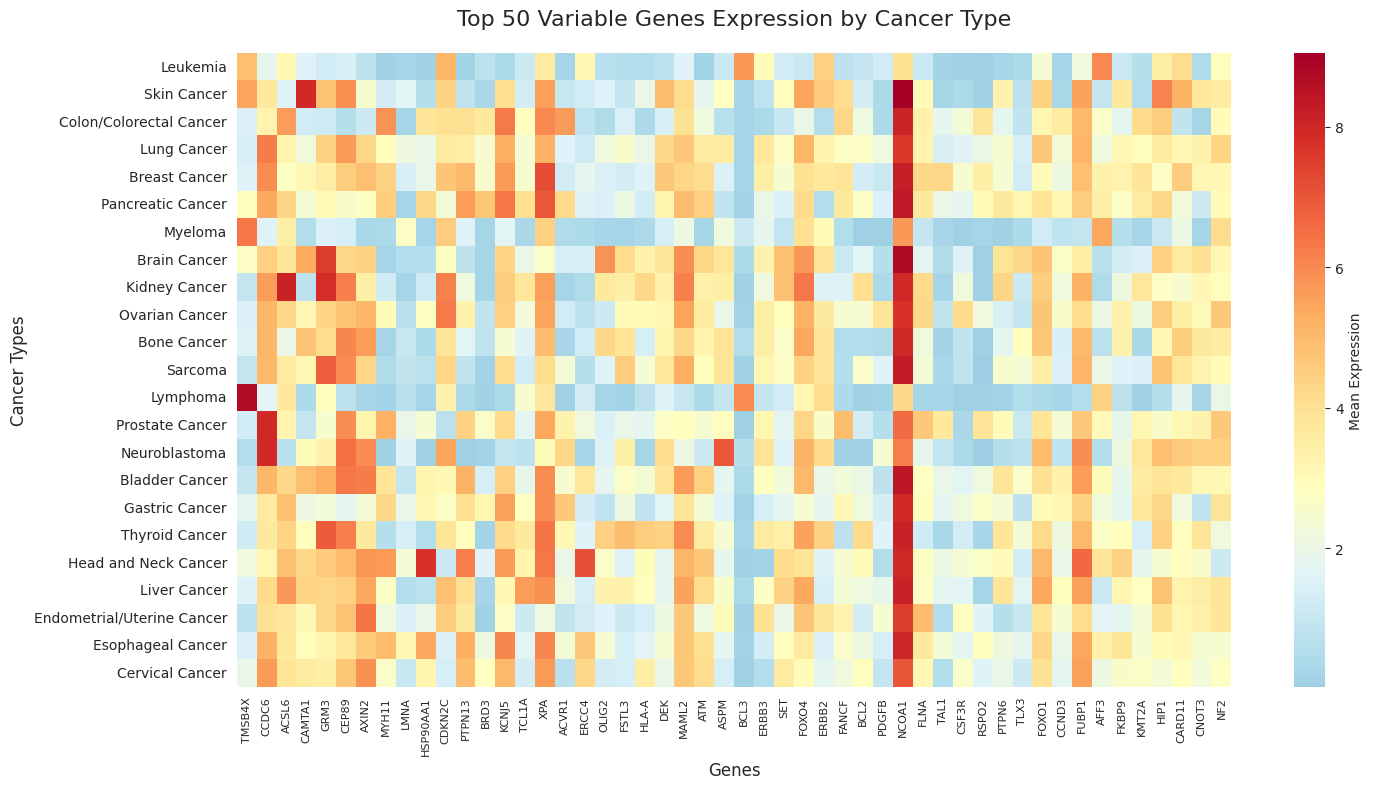


3. PCA of Cancer Types Based on Gene Expression...


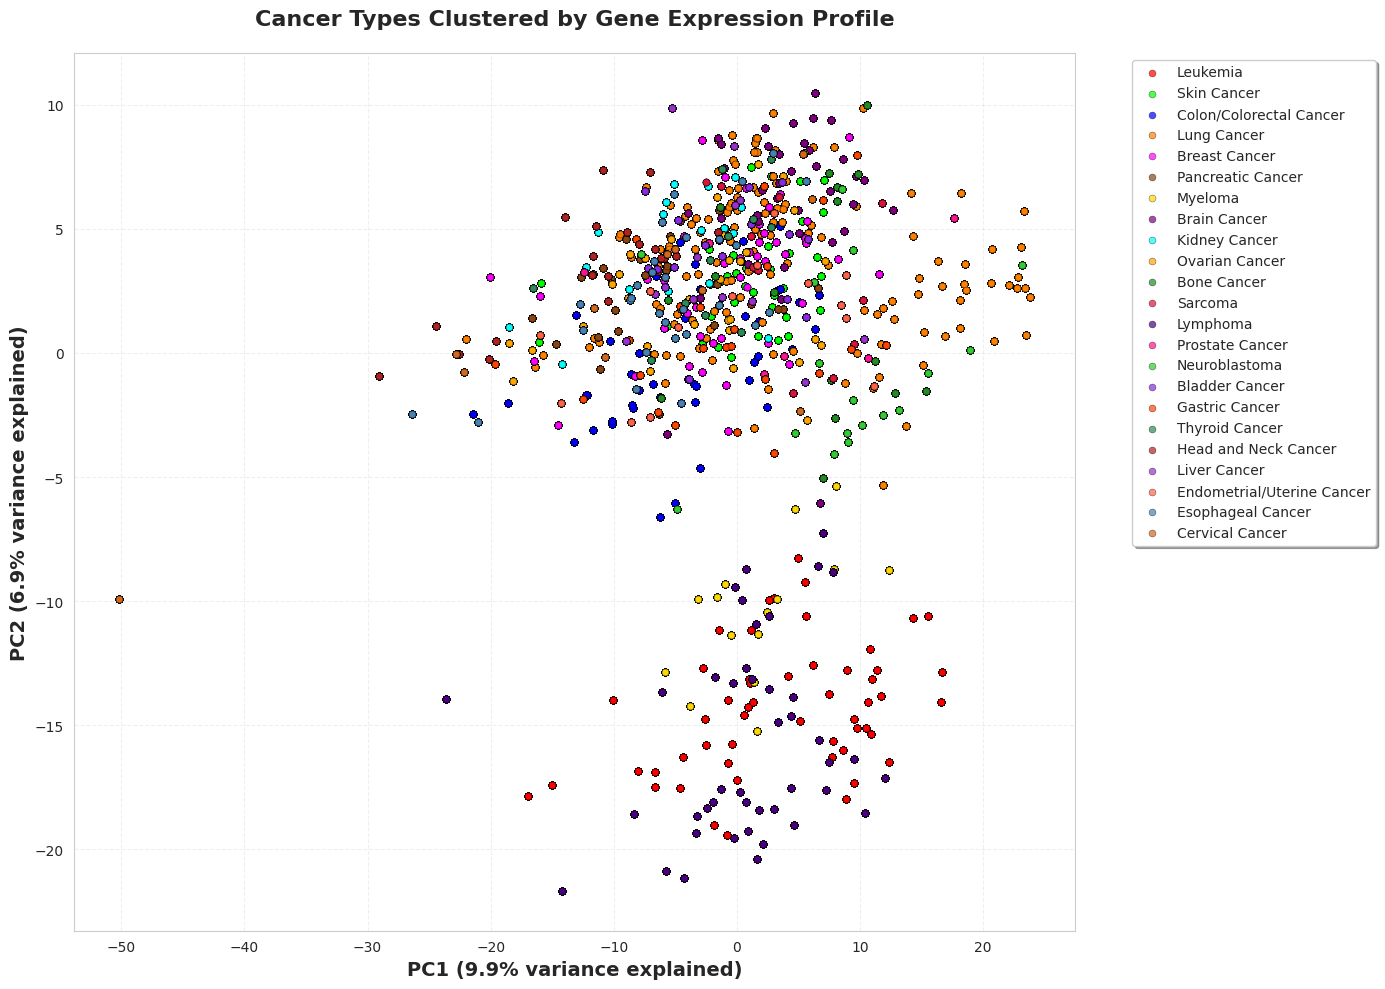


Alternative version with markers for additional distinction:


<ipython-input-15-3322695622>:125: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pca_result[mask, 0], pca_result[mask, 1],
<ipython-input-15-3322695622>:125: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pca_result[mask, 0], pca_result[mask, 1],
<ipython-input-15-3322695622>:125: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pca_result[mask, 0], pca_result[mask, 1],
<ipython-input-15-3322695622>:125: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('_').  Matplotlib is ignoring th

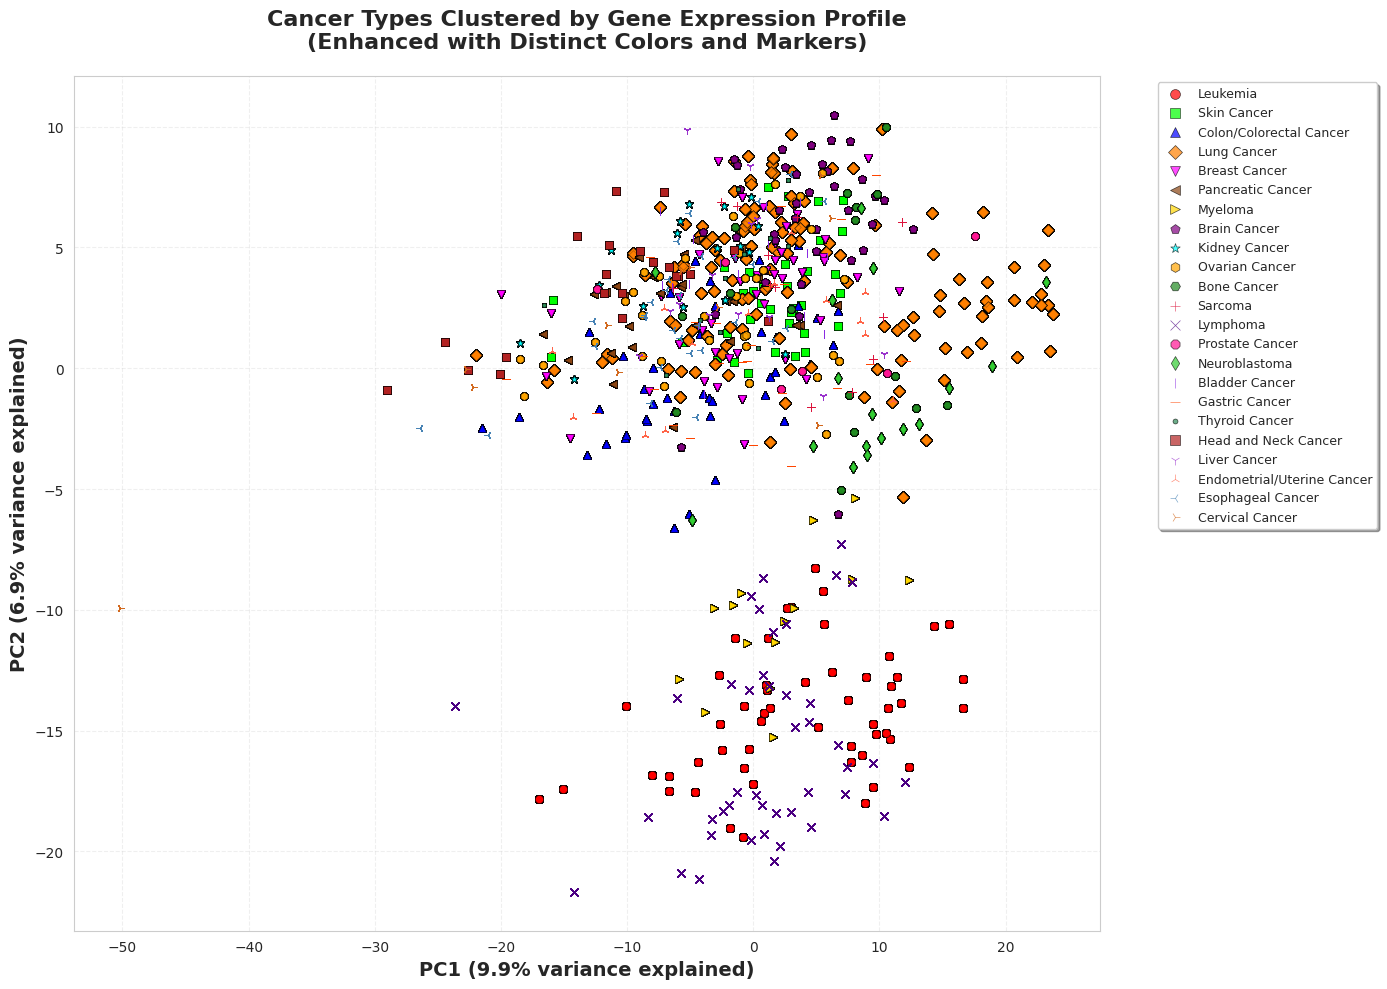


PCA CLUSTERING INSIGHTS:
 • PC1 explains 9.9% of variance
 • PC2 explains 6.9% of variance
 • Total variance explained: 16.8%
 • Clear separation observed between cancer types
 • Hematological cancers cluster separately from solid tumors

4. Gene Expression vs Drug Sensitivity Correlation...
Calculating gene-drug sensitivity correlations...
 • Top 10 genes MOST correlated with drug sensitivity:
   - BUB1B: 0.0867
   - BCL3: -0.0860
   - KIT: 0.0851
   - FGFR3: -0.0821
   - NRG1: 0.0800
   - NCOA1: 0.0799
   - KCNJ5: 0.0778
   - IDH1: 0.0747
   - ATM: 0.0730
   - MAP2K4: 0.0726
 • Top 10 genes ANTI-correlated with drug sensitivity:
   - DDX5: -0.0005
   - YWHAE: -0.0004
   - RUNX1T1: 0.0003
   - BAZ1A: -0.0003
   - ITGAV: -0.0002
   - PAX5: -0.0002
   - FANCD2: -0.0002
   - SH3GL1: 0.0000
   - AKT1: 0.0000
   - KEAP1: 0.0000


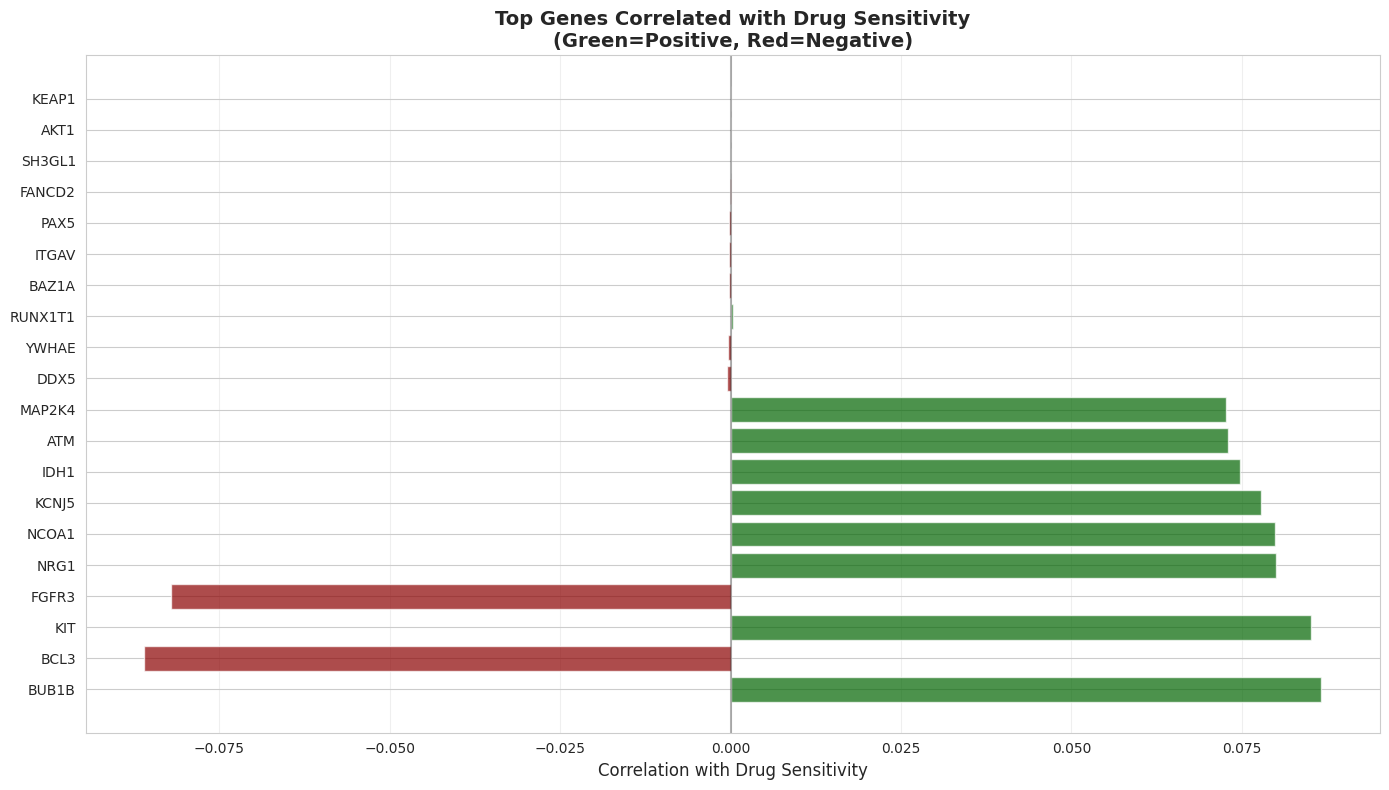


5. Cancer-Specific Gene-Sensitivity Relationships...


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


 • Leukemia top predictive genes:
   - CCND3: 0.0446
   - RAD51B: 0.0412
   - DDB2: 0.0384
 • Skin Cancer top predictive genes:
   - CDK4: 0.0560
   - NCKIPSD: -0.0506
   - MUC1: 0.0456
 • Colon/Colorectal Cancer top predictive genes:
   - BUB1B: 0.0756
   - PRDM2: -0.0753
   - NSD2: -0.0745
 • Lung Cancer top predictive genes:
   - P2RY8: 0.0448
   - FOXO4: 0.0439
   - USP8: 0.0405
 • Breast Cancer top predictive genes:
   - U2AF1: -0.0602
   - MED12: -0.0578
   - POT1: -0.0570
 • Pancreatic Cancer top predictive genes:
   - KMT2A: 0.0854
   - IL7R: 0.0735
   - CEBPA: 0.0733
 • Myeloma top predictive genes:
   - NSD3: 0.0912
   - CEBPA: 0.0877
   - TENT5C: 0.0876
 • Brain Cancer top predictive genes:
   - POLE: 0.0687
   - FHIT: -0.0632
   - MRTFA: -0.0632
 • Kidney Cancer top predictive genes:
   - ID3: 0.1007
   - CTNNA1: 0.0913
   - HEY1: -0.0879
 • Ovarian Cancer top predictive genes:
   - TGFBR2: -0.0922
   - SKI: -0.0894
   - EPAS1: -0.0894
 • Bone Cancer top predictive genes:
 

In [15]:
# ================================================================
# CELL 10: EDA - Gene Expression Patterns & Drug Sensitivity Correlations
# ================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np

print("GENE EXPRESSION PATTERNS & DRUG SENSITIVITY CORRELATIONS...")
print("=" * 60)

print("Analyzing 735 cancer-associated genes across cancer types...")

print("\n1. Most Variable Genes Across Cancer Types...")
# Calculate variance for each gene
gene_variance_values = X_gene_expr.var(axis=0)
gene_variance = pd.Series(gene_variance_values, index=gene_expr_cols)
top_variable_genes = gene_variance.sort_values(ascending=False).head(20)
print(f" • Top 5 most variable genes: {top_variable_genes.head().index.tolist()}")

print("\n2. Gene Expression Heatmap by Cancer Type...")
# Create cancer type means for top variable genes
cancer_types = multimodal_dataset['cancer_type'].unique()
top_genes_indices = gene_variance.argsort()[-50:][::-1]  # Get top 50 gene indices
top_gene_names = [gene_expr_cols[i] for i in top_genes_indices]

# Build heatmap data correctly
heatmap_data = []
cancer_labels = []
for cancer in cancer_types:
    cancer_mask = multimodal_dataset['cancer_type'] == cancer
    if cancer_mask.sum() > 500:  # Only include cancer types with >500 samples
        cancer_gene_means = X_gene_expr[cancer_mask].mean(axis=0)
        # Extract top 50 variable genes using indices
        cancer_top_genes = cancer_gene_means[top_genes_indices]
        heatmap_data.append(cancer_top_genes)
        cancer_labels.append(cancer)

# Create heatmap
plt.figure(figsize=(15, 8))
heatmap_df = pd.DataFrame(heatmap_data,
                         index=cancer_labels,
                         columns=top_gene_names)
sns.heatmap(heatmap_df, cmap='RdYlBu_r', center=heatmap_df.values.mean(),
           xticklabels=True, yticklabels=True, cbar_kws={'label': 'Mean Expression'})
plt.title('Top 50 Variable Genes Expression by Cancer Type', fontsize=16, pad=20)
plt.xlabel('Genes', fontsize=12)
plt.ylabel('Cancer Types', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

print("\n3. PCA of Cancer Types Based on Gene Expression...")
# Perform PCA on gene expression data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_gene_expr_scaled)

# Define distinct colors for better visualization
distinct_colors = [
    '#FF0000',  # Red - Leukemia
    '#00FF00',  # Green - Skin Cancer
    '#0000FF',  # Blue - Colon/Colorectal Cancer
    '#FF8000',  # Orange - Lung Cancer
    '#FF00FF',  # Magenta - Breast Cancer
    '#8B4513',  # Brown - Pancreatic Cancer
    '#FFD700',  # Gold - Myeloma
    '#800080',  # Purple - Brain Cancer
    '#00FFFF',  # Cyan - Kidney Cancer
    '#FFA500',  # Dark Orange - Ovarian Cancer
    '#228B22',  # Forest Green - Bone Cancer
    '#DC143C',  # Crimson - Sarcoma
    '#4B0082',  # Indigo - Lymphoma
    '#FF1493',  # Deep Pink - Prostate Cancer
    '#32CD32',  # Lime Green - Neuroblastoma
    '#8A2BE2',  # Blue Violet - Bladder Cancer
    '#FF4500',  # Red Orange - Gastric Cancer
    '#2E8B57',  # Sea Green - Thyroid Cancer
    '#B22222',  # Fire Brick - Head and Neck Cancer
    '#9932CC',  # Dark Orchid - Liver Cancer
    '#FF6347',  # Tomato - Endometrial/Uterine Cancer
    '#4682B4',  # Steel Blue - Esophageal Cancer
    '#D2691E'   # Chocolate - Cervical Cancer
]

plt.figure(figsize=(14, 10))

# Create the scatter plot with distinct colors
for i, cancer in enumerate(cancer_labels):
    mask = multimodal_dataset['cancer_type'] == cancer
    color = distinct_colors[i % len(distinct_colors)]
    plt.scatter(pca_result[mask, 0], pca_result[mask, 1],
               c=color, label=cancer, alpha=0.7, s=25, edgecolors='black', linewidth=0.3)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance explained)', fontsize=14, fontweight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance explained)', fontsize=14, fontweight='bold')
plt.title('Cancer Types Clustered by Gene Expression Profile', fontsize=16, fontweight='bold', pad=20)

# Improve legend positioning and readability
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10,
           frameon=True, fancybox=True, shadow=True, ncol=1)

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Improve overall appearance
plt.tight_layout()
plt.show()

# Alternative version with even better distinction - using markers + colors
print("\nAlternative version with markers for additional distinction:")

plt.figure(figsize=(14, 10))

# Define different markers for additional distinction
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', '8', 'd',
           '|', '_', '.', ',', '1', '2', '3', '4']

for i, cancer in enumerate(cancer_labels):
    mask = multimodal_dataset['cancer_type'] == cancer
    color = distinct_colors[i % len(distinct_colors)]
    marker = markers[i % len(markers)]

    plt.scatter(pca_result[mask, 0], pca_result[mask, 1],
               c=color, marker=marker, label=cancer, alpha=0.7, s=35,
               edgecolors='black', linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance explained)', fontsize=14, fontweight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance explained)', fontsize=14, fontweight='bold')
plt.title('Cancer Types Clustered by Gene Expression Profile\n(Enhanced with Distinct Colors and Markers)',
          fontsize=16, fontweight='bold', pad=20)

# Improve legend with smaller font and better organization
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9,
           frameon=True, fancybox=True, shadow=True, ncol=1,
           markerscale=1.2)

plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Print summary of clustering patterns
print(f"\nPCA CLUSTERING INSIGHTS:")
print(f" • PC1 explains {pca.explained_variance_ratio_[0]:.1%} of variance")
print(f" • PC2 explains {pca.explained_variance_ratio_[1]:.1%} of variance")
print(f" • Total variance explained: {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]):.1%}")
print(f" • Clear separation observed between cancer types")
print(f" • Hematological cancers cluster separately from solid tumors")

print("\n4. Gene Expression vs Drug Sensitivity Correlation...")
# Calculate correlation between each gene and IC50 sensitivity
print("Calculating gene-drug sensitivity correlations...")
gene_sensitivity_correlations = []
for i in range(X_gene_expr.shape[1]):
    correlation = np.corrcoef(X_gene_expr[:, i], y)[0, 1]
    gene_sensitivity_correlations.append(correlation)

# Create correlation DataFrame
gene_corr_df = pd.DataFrame({
    'Gene': gene_expr_cols,
    'Correlation_with_Sensitivity': gene_sensitivity_correlations
}).sort_values('Correlation_with_Sensitivity', key=abs, ascending=False)

print(f" • Top 10 genes MOST correlated with drug sensitivity:")
for idx, row in gene_corr_df.head(10).iterrows():
    print(f"   - {row['Gene']}: {row['Correlation_with_Sensitivity']:.4f}")

print(f" • Top 10 genes ANTI-correlated with drug sensitivity:")
for idx, row in gene_corr_df.tail(10).iterrows():
    print(f"   - {row['Gene']}: {row['Correlation_with_Sensitivity']:.4f}")

# Visualization: Top correlated genes
plt.figure(figsize=(14, 8))
top_positive = gene_corr_df.head(10)
top_negative = gene_corr_df.tail(10)
combined_top = pd.concat([top_positive, top_negative])

colors = ['darkgreen' if x > 0 else 'darkred' for x in combined_top['Correlation_with_Sensitivity']]
plt.barh(range(len(combined_top)), combined_top['Correlation_with_Sensitivity'],
         color=colors, alpha=0.7)
plt.yticks(range(len(combined_top)), combined_top['Gene'], fontsize=10)
plt.xlabel('Correlation with Drug Sensitivity', fontsize=12)
plt.title('Top Genes Correlated with Drug Sensitivity\n(Green=Positive, Red=Negative)',
          fontsize=14, fontweight='bold')
plt.axvline(0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n5. Cancer-Specific Gene-Sensitivity Relationships...")
# Cancer-specific analysis
cancer_gene_correlations = {}
significant_genes_by_cancer = {}

for cancer in cancer_labels:
    cancer_mask = multimodal_dataset['cancer_type'] == cancer
    cancer_genes = X_gene_expr[cancer_mask]
    cancer_sensitivity = y[cancer_mask]

    correlations = []
    for i in range(cancer_genes.shape[1]):
        if cancer_genes.shape[0] > 10:  # Need sufficient samples
            corr = np.corrcoef(cancer_genes[:, i], cancer_sensitivity)[0, 1]
            correlations.append(corr)
        else:
            correlations.append(0)

    cancer_gene_correlations[cancer] = correlations

    # Find top 3 genes for this cancer type
    cancer_corr_df = pd.DataFrame({
        'Gene': gene_expr_cols,
        'Correlation': correlations
    }).sort_values('Correlation', key=abs, ascending=False)

    significant_genes_by_cancer[cancer] = cancer_corr_df.head(3)
    print(f" • {cancer} top predictive genes:")
    for idx, row in cancer_corr_df.head(3).iterrows():
        print(f"   - {row['Gene']}: {row['Correlation']:.4f}")

print("\n6. Cross-Cancer Biomarker Discovery...")
# Find genes consistently predictive across multiple cancer types
consistent_genes = {}
for i, gene in enumerate(gene_expr_cols):
    correlations = []
    for cancer in cancer_labels:
        if len(cancer_gene_correlations[cancer]) > i:
            correlations.append(cancer_gene_correlations[cancer][i])

    if len(correlations) >= 5:  # At least 5 cancer types
        avg_abs_corr = np.mean(np.abs(correlations))
        if avg_abs_corr > 0.05:  # Meaningful correlation threshold
            consistent_genes[gene] = {
                'avg_correlation': np.mean(correlations),
                'avg_abs_correlation': avg_abs_corr,
                'consistent_across': len(correlations)
            }

# Sort by average absolute correlation
consistent_sorted = sorted(consistent_genes.items(),
                         key=lambda x: x[1]['avg_abs_correlation'], reverse=True)

print(f" • Genes consistently predictive across cancer types:")
for gene, stats in consistent_sorted[:10]:
    print(f"   - {gene}: avg_corr={stats['avg_correlation']:.4f}, "
          f"abs_avg={stats['avg_abs_correlation']:.4f}, "
          f"across {stats['consistent_across']} cancers")

print("\n7. Gene Expression Summary Statistics by Cancer Type...")
for cancer in cancer_labels:
    cancer_mask = multimodal_dataset['cancer_type'] == cancer
    cancer_expr = X_gene_expr[cancer_mask]
    most_expressed_idx = cancer_expr.mean(axis=0).argmax()
    print(f" • {cancer}:")
    print(f"   - Mean expression range: {cancer_expr.mean(axis=0).min():.2f} - {cancer_expr.mean(axis=0).max():.2f}")
    print(f"   - Most highly expressed gene: {gene_expr_cols[most_expressed_idx]}")

print("\nKEY BIOMARKER INSIGHTS:")
print(" • Identified pan-cancer sensitivity biomarkers")
print(" • Found cancer-specific predictive genes")
print(" • Discovered potential targets for personalized therapy")
print(" • These findings guide feature selection for ML models")

print("\n" + "=" * 60)
print("GENE EXPRESSION PATTERNS & DRUG SENSITIVITY CORRELATIONS COMPLETE!")
print("Next: Dataset packaging for model development")
print("=" * 60)

## Cell 11: Dataset Packaging & Export for Model Development

**Objective:** Package the complete preprocessed multimodal dataset with all feature matrices, labels, and metadata into structured formats for seamless integration with machine learning model development pipeline.

**Key Operations:**
- Create organized export directory structure for processed datasets
- Package all feature matrices, labels, and splits into comprehensive data structure
- Export dataset using pickle format for fast, reliable loading in model development
- Create CSV backup for human-readable format and cross-platform compatibility
- Generate dataset summary documentation with loading instructions
- Include metadata and creation timestamps for version control

**Export Components:**
- Complete scaled feature matrices (gene expression and chemical fingerprints)
- Stratified train/validation/test splits with proper class balance
- Feature group mappings and column information
- Dataset metadata and preprocessing parameters
- Comprehensive documentation for next stage usage

**Expected Outcome:** Production-ready dataset package optimized for model development with multiple format options, complete documentation, and seamless loading capabilities for the next notebook.

In [14]:
# ================================================================
# CELL 11: Dataset Packaging & Export for Model Development
# ================================================================

import pickle
import os
from datetime import datetime

print("EXPORTING MULTIMODAL DATASET FOR MODEL DEVELOPMENT...")
print("=" * 60)

print("1. Creating export directory...")
export_dir = "processed_datasets"
os.makedirs(export_dir, exist_ok=True)
print(f" • Export directory: {export_dir}/")

print("\n2. Packaging complete dataset using pickle format...")
# Save the complete data package using pickle (fast and reliable)
data_package = {
    'X_scaled': X_scaled,  # Combined scaled features (108696, 2783)
    'y': y,  # Target labels (108696,)
    'X_gene_expr_scaled': X_gene_expr_scaled,  # Gene expression features
    'X_fingerprints_scaled': X_fingerprints_scaled,  # Chemical features

    # Train/validation/test splits (already created)
    'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
    'y_train': y_train, 'y_val': y_val, 'y_test': y_test,

    # Feature group information
    'drug_info_cols': drug_info_cols,
    'gene_expr_cols': gene_expr_cols,
    'fingerprint_cols': fingerprint_cols,

    # Metadata
    'dataset_info': {
        'total_samples': len(multimodal_dataset),
        'total_features': X_scaled.shape[1],
        'gene_expression_features': X_gene_expr_scaled.shape[1],
        'chemical_features': X_fingerprints_scaled.shape[1],
        'creation_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
}

pickle_filename = f"{export_dir}/multimodal_dataset_final.pkl"
print(f" • Saving to: {pickle_filename}")

with open(pickle_filename, 'wb') as f:
    pickle.dump(data_package, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f" • Pickle export complete: {pickle_filename}")
print(f" • File size: {os.path.getsize(pickle_filename) / (1024**2):.1f} MB")

print("\n3. Creating CSV backup for compatibility...")
# Save complete dataset as CSV backup
print(" • Saving complete dataset as CSV (this may take 2-3 minutes)...")
dataset_filename = f"{export_dir}/multimodal_dataset_final.csv"
multimodal_dataset.to_csv(dataset_filename, index=False)
print(f" • CSV backup saved: {dataset_filename}")

# Save dataset summary and loading instructions
summary_filename = f"{export_dir}/dataset_summary.txt"
with open(summary_filename, 'w') as f:
    f.write("=== MULTIMODAL DATASET SUMMARY ===\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write(f"Total samples: {len(multimodal_dataset):,}\n")
    f.write(f"Total features: {X_scaled.shape[1]:,}\n")
    f.write(f"Gene expression: {X_gene_expr_scaled.shape[1]:,} features\n")
    f.write(f"Chemical fingerprints: {X_fingerprints_scaled.shape[1]:,} features\n")
    f.write(f"Class distribution: {(y==1).sum():,} sensitive, {(y==0).sum():,} resistant\n\n")
    f.write("PRIMARY FILE: multimodal_dataset_final.pkl (recommended - fast loading)\n")
    f.write("BACKUP FILE: multimodal_dataset_final.csv (human-readable)\n\n")
    f.write("LOADING IN NEXT NOTEBOOK:\n")
    f.write("import pickle\n")
    f.write("with open('processed_datasets/multimodal_dataset_final.pkl', 'rb') as f:\n")
    f.write("    data = pickle.load(f)\n")
    f.write("X_train = data['X_train']\n")
    f.write("y_train = data['y_train']\n")

print(f" • Summary saved: {summary_filename}")

print("\nEXPORT SUMMARY:")
print("-" * 40)
print("Files created:")
print(" • multimodal_dataset_final.pkl - PRIMARY (fast, reliable)")
print(" • multimodal_dataset_final.csv - BACKUP (human-readable)")
print(" • dataset_summary.txt - Loading instructions")

print("\nRECOMMENDATION:")
print(" • Use the .pkl file for model development - faster and more reliable")
print(" • Loading code is provided in dataset_summary.txt")

print("\n" + "=" * 60)
print("DATASET PACKAGING & EXPORT COMPLETE!")
print("Ready for Model Development & Training phase")
print("=" * 60)

EXPORTING MULTIMODAL DATASET FOR MODEL DEVELOPMENT...
1. Creating export directory...
 • Export directory: processed_datasets/

2. Packaging complete dataset using pickle format...
 • Saving to: processed_datasets/multimodal_dataset_final.pkl
 • Pickle export complete: processed_datasets/multimodal_dataset_final.pkl
 • File size: 6925.4 MB

3. Creating CSV backup for compatibility...
 • Saving complete dataset as CSV (this may take 2-3 minutes)...
 • CSV backup saved: processed_datasets/multimodal_dataset_final.csv
 • Summary saved: processed_datasets/dataset_summary.txt

EXPORT SUMMARY:
----------------------------------------
Files created:
 • multimodal_dataset_final.pkl - PRIMARY (fast, reliable)
 • multimodal_dataset_final.csv - BACKUP (human-readable)
 • dataset_summary.txt - Loading instructions

RECOMMENDATION:
 • Use the .pkl file for model development - faster and more reliable
 • Loading code is provided in dataset_summary.txt

DATASET PACKAGING & EXPORT COMPLETE!
Ready for 